In [117]:
import glob
import importlib
import sys, os

import numpy as np
import scipy.optimize as op
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FormatStrFormatter)

import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from itertools import cycle

import emcee
import importlib.resources as importlib_resources
# import synphot

from dust_extinction.averages import G03_SMCBar
from dust_extinction.averages import G03_LMCAvg
from dust_extinction.parameter_averages import F19
# from dust_extinction.averages import G03_SMCBar

import measure_extinction
from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

from measure_extinction.plotting.plot_spec import plot_multi_spectra, plot_spectrum
from measure_extinction.merge_obsspec import _wavegrid
from measure_extinction.utils import scale_spex_spec
import extinction_ensemble_props

# from hst_smc_ext.utils import fit_uv_ext_fm90

file_path = "/Users/pyanchulova/Documents/extstar_data/"
savefile_path = "/Users/pyanchulova/Documents/ext-science/figs/"
folder = ""

# STIS data location
#karl_data_path = "~/../../user/kgordon/Python_git/extstar_data/STIS_Data/"

if not os.path.isdir(savefile_path + folder):
    print("making new dir", (savefile_path + folder))
    os.system("mkdir " + savefile_path + folder)

galaxy = "m31" #"m33" # "m31"
gal_str = galaxy + "_"

m31_list = [
            # "m31_e1_j004354.05+412626.0",
            # "m31_e2_j004413.84+414903.9", 
            # "m31_e3_j004420.52+411751.1",
            # "m31_e4_j004427.47+415150.0",
            # "m31_e5_j004431.66+413612.4", # So-so fit, phot issues, with F336W (excluded, fit is better)
            # "m31_e6_j004438.71+415553.5", # Fit w/ e22: 3-band phot
            # "m31_e7_j004454.37+412823.9",
            # "m31_e8_j004511.82+415025.3",
            # "m31_e9_j004511.85+413712.9", 
            # "m31_e12_j004539.00+415439.0",
            # "m31_e13_j004539.70+415054.8",
            # "m31_e14_j004543.46+414513.6",
            # "m31_e15_j004546.81+415431.7",
            # "m31_e17_j003944.71+402056.2", # Fit w/ e18 & e24: UBVRI phot
            # "m31_e18_j003958.22+402329.0", # Fit w/ e17 & e24: UBVRI phot
            # "m31_e22_j004034.61+404326.1", # Fit w/ e6: 3-band phot
            "m31_e24_j004412.17+413324.2", # Fit w/ e17 & e28: UBVRI phot
            ]
m33_list = ["m33_e1_j013334.26+303327", 
            "m33_e2_j013339.52+304540",
            #"m33_e3_j013250.80+303507", 
            "m33_e4_j013344.59+304436", 
            #"m33_e5_j013406.63+304147", 
            #"m33_e6_j013410.59+304616", 
            "m33_e7_j012241.93+304728", 
            #"m33_e8_j013416.10+303344.9"
           ]

relband = "ACS_F475W"
relband_str = "$F475W$"
nof275w = True

# If only fitting stars with WFPC2 photometry
if len(m31_list) <= 2:
    for i in range(len(m31_list)):
        if 'e17' in m31_list[i]:
            print("e17 in m31_list")
            relband = "WFPC2_F439W"
            relband_str = "$F439W$"

for i in range(len(m31_list)):
    if 'e17' in m31_list[i] or 'e18' in m31_list[i]: # or 'e24' in m31_list[i]:
        print("e17 and/or e18 and/or e24 in m31_list")
        relband = "V"

for i in range(len(m31_list)):
    if 'e24' in m31_list[i]:
        print("e24 in m31_list")
        relband = "ACS_F814W"
        relband_str = "$F814W$"

velocity = -109.3 # M31 radial velocity from NED
if galaxy == 'm33':
    velocity = -179.2 # M33 radial velocity from NED
    m31_list = m33_list
else:
    velocity = -109.3 # M31 radial velocity from NED

# to test aquisition of fstarname
starname = m31_list[0]
fstarname = f"{starname}.dat"

starstr = starname.split(gal_str)[1].split("_")[0]
print("starname and starstr", starname, starstr)
fontsize=14

print("stars list:", m31_list)
print("gal_str:", gal_str)
print("relband:", relband)

rwaverange = [0.1, 0.32] * u.micron
gres = 150

e24 in m31_list
starname and starstr m31_e24_j004412.17+413324.2 e24
stars list: ['m31_e24_j004412.17+413324.2']
gal_str: m31_
relband: ACS_F814W


In [2]:
ref = importlib_resources.files("dust_extinction") / "data"

### (Done: one-time) Format HI foreground correction fits file

In [2]:
t = Table.read('hi_foregrounds_m31.fits')
t.add_column(['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e12', 'e13', 'e14', 'e15', 'e17', 'e18', 'e22', 'e24'], 
             name="star", index=0)
t.write('hi_foregrounds_m31_id.fits') 

OSError: File hi_foregrounds_m31_id.fits already exists. If you mean to replace it then use the argument "overwrite=True".

### Read in the star data

In [74]:
def get_red_star(fstarname, file_path, excl_zero=True, excl_wls=True, get_excl_inds=False, 
                 rebin=True, rbres=750, fourband=False, nof275w=True,
                 excl_ends=True, lenendremflux=1, beg_wls=[.1141, .1148], 
                 end_wls=[.3136, .3155]):
    """

    Sample call: red_star, band_names, data_names = get_red_star(fstarname, file_path)
    
    excl_wls:   list. default=False
                    exclude data in the range given by excl_wls (170-200 nm for some stars)
    beg_wls:    [.1141, .1148]
    end_wls:    [.3136, .3155]
    

    """
    # get the observed reddened star data
    reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
    # self.data[curtype].fluxes[self.data[curtype].npts == 0] = np.nan
    
    # print("reddened_star.data.keys()", reddened_star.data.keys())

    if excl_ends:
        # print("Removing ends")

        for curtype in reddened_star.data.keys():
            (gindxsends,) = np.where(
                ((reddened_star.data[curtype].waves.to(u.micron).value >= beg_wls[0])
                & (reddened_star.data[curtype].waves.to(u.micron).value <= beg_wls[1]))
                | ((reddened_star.data[curtype].waves.to(u.micron).value >= end_wls[0])
                & (reddened_star.data[curtype].waves.to(u.micron).value <= end_wls[1]))
            )
            excl_fluxes_ends = reddened_star.data[curtype].fluxes[gindxsends]
            # reddened_star.data[curtype].fluxes[gindxsends] = np.nan
            reddened_star.data[curtype].npts[gindxsends] = 0 #np.nan #0
            reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan

    # Exclude a WL range
    if excl_wls:
        
        if get_excl_inds:
            # rebin spectra here, to accomplish rebinning of gindxs for plotting
            reddened_star.data["STIS"].rebin_constres(rwaverange, gres)
        for curtype in reddened_star.data.keys():
            gindxs_arr=[]

            # Implement for X number of excluded regions
            # for i in range(len(excl_wls)):
            #     print('i, in get_red_star', i )
            #     if (i%2) != 0:
            #         print('(i%2) != 0')
            #         continue
            #     else:
            #         cutinds = np.where(
            #                             (reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[i])
            #                             & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[i+1])
            #                             )
            #         gindxs_arr.append(cutinds)
                    
            # single wl range
            if len(excl_wls) == 2:
                print('one excluded region')
                (gindxs,) = np.where(
                                    (reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[0])
                                    & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[1])
                                    )
            # two wl ranges
            elif (len(excl_wls) > 2) & (len(excl_wls) < 5):
                print('two excluded regions')
                (gindxs,) = np.where(
                                    ((reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[0])
                                    & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[1]))
                                    |
                                    ((reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[2])
                                    & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[3]))
                                    )
            # three wl ranges
            elif (len(excl_wls) > 4) & (len(excl_wls) < 7):
                print('three excluded regions')
                (gindxs,) = np.where(
                                    ((reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[0])
                                    & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[1]))
                                    |
                                    ((reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[2])
                                    & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[3]))
                                    |
                                    ((reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[4])
                                    & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[5]))
                                    )
            # Turn (gindxs,) into a form equivalent to ex_regions in set_weights()
            # (gindxs,) = tuple(gindxs_arr)
            
            # print('EXCLUDING WVLS')
            excl_fluxes = reddened_star.data[curtype].fluxes[gindxs]
            # Only set fluxes to NaN if not returning excluded fluxes and their indices for plotting
            if get_excl_inds is False:
                reddened_star.data[curtype].npts[gindxs] = 0
                # reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan
                reddened_star.data[curtype].fluxes[gindxs] = np.nan
    else:
        gindxs=None
        excl_fluxes=None
        

    # Remove negative fluxes
    (nvals,) = np.where(reddened_star.data["STIS"].fluxes < 0)
    reddened_star.data["STIS"].npts[nvals] = 0

    # Turn zeros into NaNs
    reddened_star.data["STIS"].fluxes[reddened_star.data["STIS"].npts == 0] = np.nan

    # Implement rebinning here eventually
#     if rebin:
#         print("Rebinning spectra to {} res".format(rbres))
#         gres = 750
#         rwaverange = [0.11, 0.32] * u.micron
#         reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

    # reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan
            
    band_names = reddened_star.data["BAND"].get_band_names()
    data_names = reddened_star.data.keys()
    # print("band bames, pre cutting bands", band_names)
    
    if fourband:
        print("Obtaining 4 band names only")
        band_names = band_names[0:4]

    # print("band bames", band_names)

    return reddened_star, band_names, data_names, gindxs, excl_fluxes
    

In [4]:
fontsize = 18
font = {"size": fontsize}
plt.rc("font", **font)

### Read in models (choose rebinned or not)

In [75]:
rebin=True
rwaverange=None
gres=None
if rebin:
    gres=150
    rwaverange = [0.1, 0.32] * u.micron
    print('Rebinned', rwaverange, "to", gres)

tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v10.dat".format(file_path))
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

fourband=False

# run just to get band names and spectra for ModelData
for i in range(len(m31_list)):
    if ('e22' in m31_list[i]) or ('e6' in m31_list[i]):
        fourband=True
        
# run line just to get band names and spectra needed for ModelData
for i in range(len(m31_list)):
    # 4-band photometry
    if 'e24' in m31_list[i]:
        if i==0:
            print("Models for e24: no F475W photometry")
            red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, excl_wls=False)
    elif ('e22' in m31_list[i]) or ('e6' in m31_list[i]):
        if i==0:
            print("Models for e22 and e6: 3-band photometry!")
            red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, fourband=fourband, excl_wls=False)
    # UBVRI photometry
    elif('e17' in m31_list[i]) or ('e18' in m31_list[i]) or ('e24' in m31_list[i]):
        if i==0:
            print('Models for e17, e18, e24: UBVRI photometry!')
            red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, nof275w=False, excl_wls=False)
    # Full-band PHAT photometry
    else:
        # Otherwise skip F275W (2/29/24)
        if i==0:
            red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, nof275w=True, excl_wls=False)
print("band_names post cut", band_names)

modinfo_rb = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
    rebin=rebin,
    waverange=rwaverange,
    resolution=gres
)

Rebinned [0.1  0.32] micron to 150
Models for e24: no F475W photometry
band_names post cut ['WFC3_F336W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']


### Optional code blocks (test zero flux excl, phot scaling, test rebining

#### (optional) Test plot model rebin

In [61]:
plot_non_rb = True

# Also plot non-rebinned model for comparison
if plot_non_rb:
    modinfo_not_rb = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
    )

/Users/pyanchulova/Documents/ext-science/measure_extinction/stardata.py:429: UserWarning: cannot get flux for WFPC2_F255W
  warnings.warn("cannot get flux for %s" % band_name, UserWarning)


TypeError: 'NoneType' object is not subscriptable

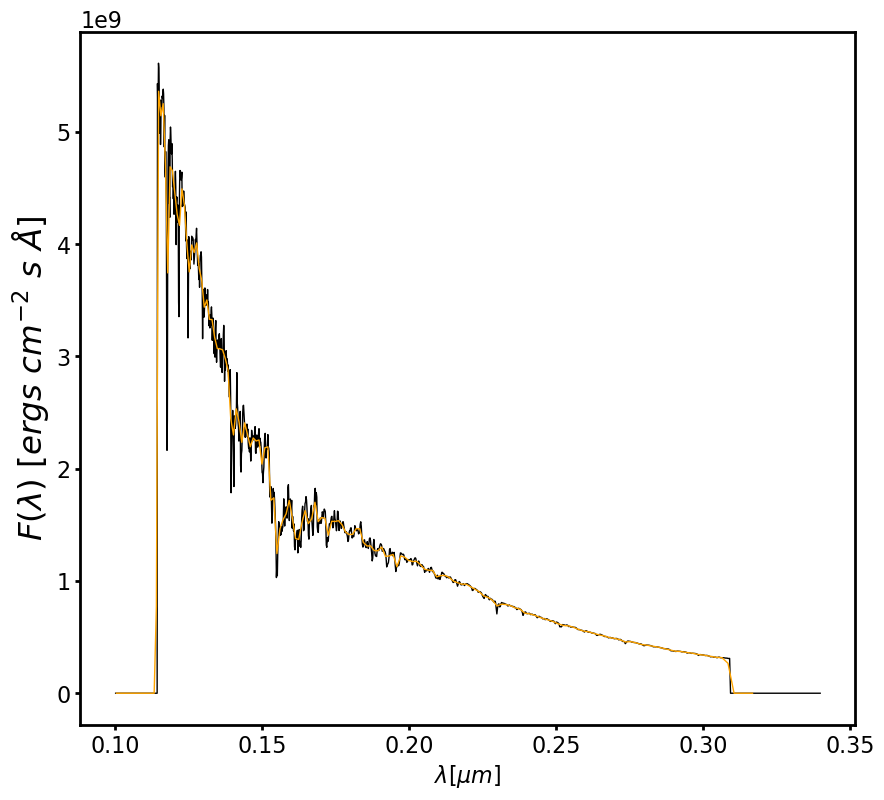

In [46]:
fig, ax = plt.subplots(figsize=(10, 9))
spec_n=410

for i in range(1):
    if plot_non_rb:
        ax.plot(
            modinfo_not_rb.waves["STIS"], 
            modinfo_not_rb.fluxes["STIS"][spec_n], c='k')
    ax.plot(
        modinfo_rb.waves["STIS"], 
        modinfo_rb.fluxes["STIS"][spec_n], c='orange'
        )
ax.set_xlabel("$\lambda [\mu m]$")
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
plt.savefig(savefile_path + "/mod_spec_gres_" + str(gres) + ".pdf")

#### (optional) Test exclusion of zero-flux data & exclusion of data in a WL range (.17 -- .2 um)

============ Star is m31_e13_j004539.70+415054.8 ====================
file path /Users/pyanchulova/Documents/extstar_data/
fstarname m31_e13_j004539.70+415054.8.dat
len negative nvals [False False False ... False False False]
Remove F275W? True
len negative nvals [False False False ... False False False]
zero flux [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18 172]
len zero flux 20
Remove F275W? True
================ Plotting NaN fluxes ================
Length of fluxes with naninds:  20


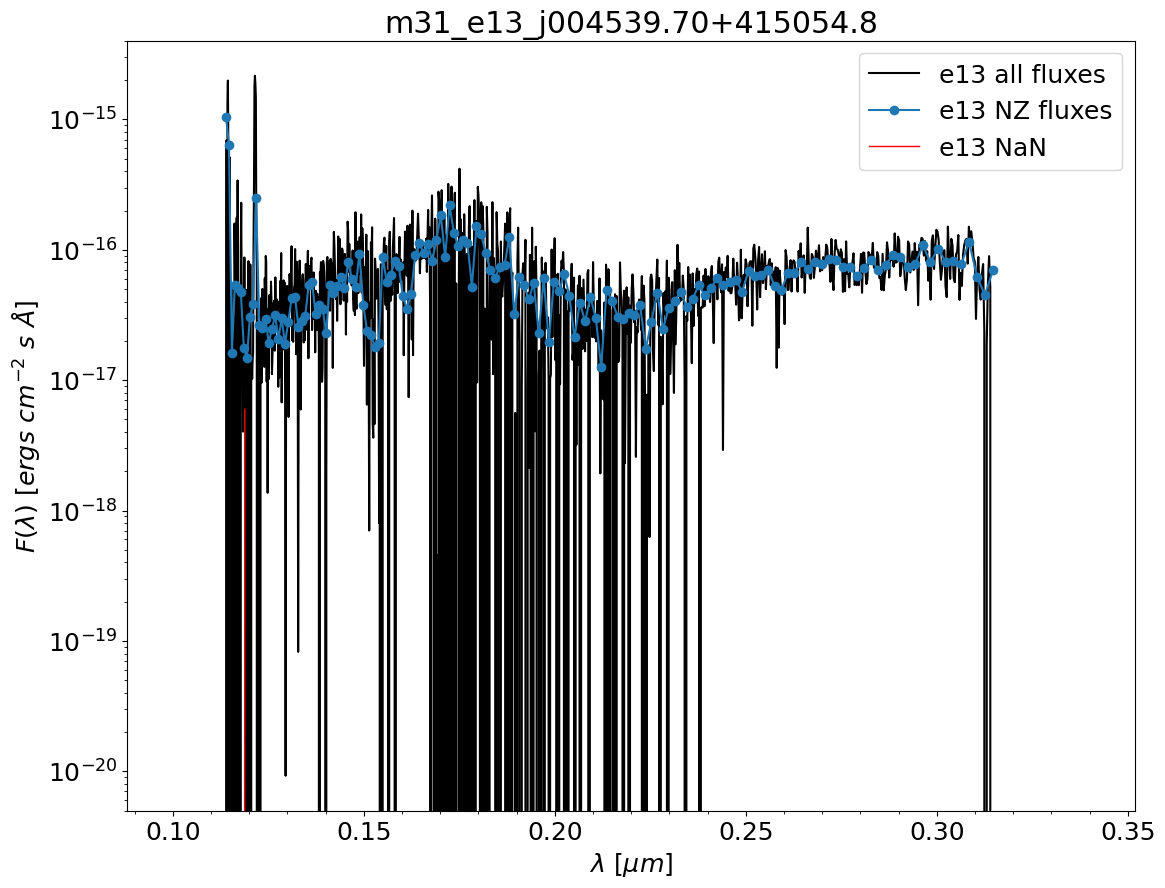

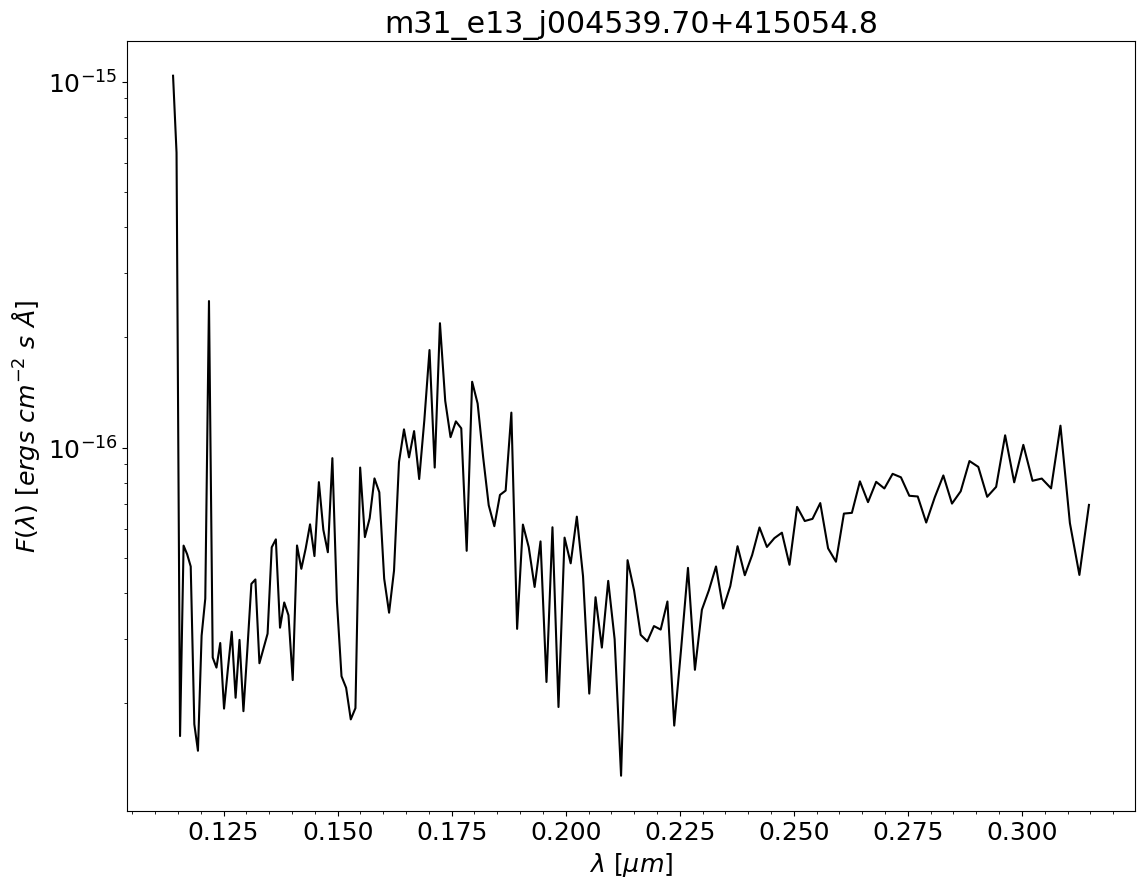

In [23]:
# m31_list=m31_list[-5:]
print (m31_list)

### (optional) Test exclusion of zero-flux data & exclusion of data in a WL range (.17 -- .2 um)

In [42]:
excl_wls = [.17, .2] # wavelength range to exclude, in microns
savefig = True

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]
    print('============ Star is %s ====================' % starname)
    print('file path', file_path)
    print('fstarname', fstarname)

    # Get star data, WITHOUT excluding zero flux, for plotting
    # gindxs are flux indices of exclided WL range
    red_star_a, band_names_a, data_names_a, gindxs, excl_fluxes, naninds_n, nan_fluxes_n = get_red_star(fstarname, 
                                                                                                    file_path, 
                                                                                                    excl_zero=False, 
                                                                                                    excl_wls=False,
                                                                                                    rebin=False   )

    # Get star data, with non-zero flux; gindxs = flux inds of exclided WL range
    red_star_nz, band_names_nz, data_names_nz, gindxs, excl_fluxes, naninds, nan_fluxes = get_red_star(fstarname, 
                                                                                                       file_path, 
                                                                                                       excl_zero=True, 
                                                                                                       excl_wls=excl_wls)
    # Not sure why these are needed
    # norm_data_a = np.average(red_star_a.data["BAND"].fluxes)
    # norm_data_nz = np.average(red_star_nz.data["BAND"].fluxes)
    # norm_flux_a = red_star_a.data["STIS"].fluxes / norm_data_a
    # norm_flux_nz = red_star_nz.data["STIS"].fluxes / norm_data_nz
    
    # print("===== naninds: %s =======" % len(naninds))
    # print("===== gindxs: %s =======" % len(gindxs))
    
    # Plot spectra, both with and w/o zero fluxes
    fig, ax = plt.subplots(figsize=(13, 10))
    ax.plot(red_star_a.data["STIS"].waves, red_star_a.data["STIS"].fluxes, "k-", label=starstr + " all fluxes")
    ax.plot(red_star_nz.data["STIS"].waves, red_star_nz.data["STIS"].fluxes, "o-", label=starstr + " NZ fluxes")

    # Plot excluded data as a dashed line
    if excl_wls:
        print("=============== Plotting excluded WLs ==============")
        ax.plot(red_star_a.data["STIS"].waves[gindxs], excl_fluxes, ls="--", lw=1, c='gray', label=starstr + " excl fluxes")
    
    # Plot NaN fluxes (there are always some)
    print("================ Plotting NaN fluxes ================")
    print('Length of fluxes with naninds: ', len(red_star_a.data["STIS"].fluxes[naninds]))
    ax.plot(red_star_a.data["STIS"].waves[naninds], red_star_a.data["STIS"].fluxes[naninds], 
            ls="-", lw=1, c='r', label=starstr + " NaN")
    
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    # ax.set_xlim(0.11,0.32)
    ylim = ax.get_ylim()
    # ax.set_ylim(-0.5e-15, 0.2e-15) # 1e-22
    ax.set_yscale("log")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.legend()
    ax.set_title(starname)
    if savefig:
        plt.savefig(savefile_path + "non_zero_flux_spectra_" + gal_str.split("_")[0] + "/" + 
                    starstr + "all_t1.png")
        plt.close()

        
    # ================== Plot only non-zero fluxes, and excluded fluxes as a dashed line =====================
    fig, ax = plt.subplots(figsize=(13, 10))
    ax.plot(red_star_nz.data["STIS"].waves, red_star_nz.data["STIS"].fluxes, "k-", label=starstr + " NZ fluxes")
    if excl_wls:
        ax.plot(red_star.data["STIS"].waves[gindxs], excl_fluxes, ls="--", lw=1, c='gray', label=starstr + " excl fluxes")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    # ax.set_xlim(0.11,0.32)
    ylim = ax.get_ylim()
    # ax.set_ylim(1e-18, ylim[1])
    ax.set_yscale("log")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_title(starname)
    # plt.legend()
    if savefig:
        plt.savefig(savefile_path + "non_zero_flux_spectra_" + gal_str.split("_")[0] + "/" + 
                    starstr + "nz_t1.png")
        plt.close()

reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end w

#### (Optional for now) Calculate spectra - photometry scaling factor

In [46]:
# various options

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]
    
    # Calculate spectra correction scaling factor after comparing photometry 
    # obtained from spectra with the band photometry
    reddened_star = StarData(fstarname, path=path)
    print(reddened_star.data.keys())
    # corfac = scale_spex_spec.calc_save_corfac_spex(starname, path=f"{file_path}/DAT_files/")



#### (optional) Plot rebinned spectra + find spec-phot corr factor (measure_extinction)

EXCLUDING fluxes


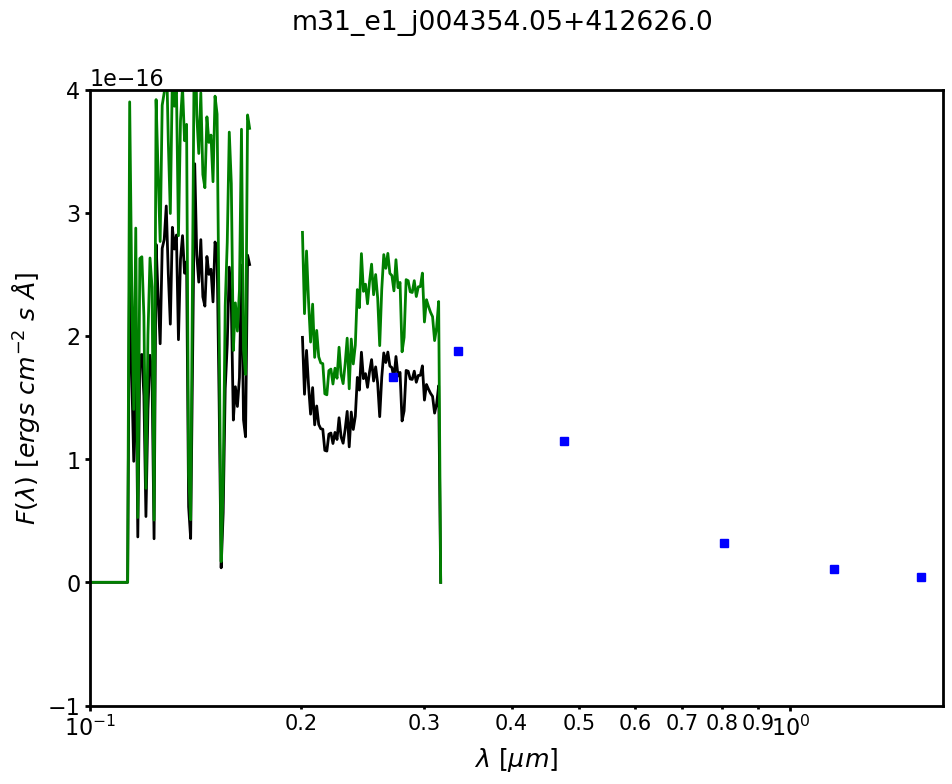

In [227]:
# Rebin params
# Tested resolutions: 125, 250, 500, 750; Data ~= 1000; > Data: 1250, 1500, 2000
rwaverange = [0.1, 0.32] * u.micron
gres = 150
plot_zoomed = False
plot_norm = False
plot_non_rebinned = False
plot_orig_res_data=False # Do we want to plot the unrebinned spectra
# m31_list=m31_list[0]

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]

    # default settings
    #plot_spectrum(starname, path)

    # Get star data; default removes zero-flux data and flux in range 0.17 - 0.2 micron 
    red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, rebin=False)
    norm_data = np.average(red_star.data["BAND"].fluxes)

    # ================== UV spectra WL range only ==============
    if plot_zoomed:
        fig, (ax,ax2) = plt.subplots(2, 1, figsize=(11, 12))
    else:
        plt.figure(figsize=(11, 8))
        ax = plt.gca()
        
    # plot the bands and all spectra for this star
    for cspec in data_names:
        ptype = "-"
        
        if cspec == "BAND":
            ptype = "s"
            label=""

        norm_flux = red_star.data[cspec].fluxes / norm_data
        if plot_norm:
            not_rb_data = norm_flux
        else:
            not_rb_data = red_star.data[cspec].fluxes
            
        if cspec == "BAND":
            clr="b" #"b"
        else:
            clr="k"

        # Plot default observations, not rebinned:
        if plot_orig_res_data:
            if cspec == "STIS":
                ax.plot(
                    red_star.data[cspec].waves,
                    not_rb_data,
                    clr + ptype,
                    label=label,
                    lw=1,
                    zorder=1
                    )            
        
        # REBIN an instance of the STIS spectra; just to show diff b/n rebined and not.
        if cspec == "STIS":

            spec_rb = red_star.data[cspec]
            spec_rb.rebin_constres(rwaverange, gres)
            rb_data = spec_rb.fluxes
            
            # ========================= Adjust spectra ===================
            spec_adj = spec_corr(galaxy, starstr)
            rb_data_adj = rb_data.value * spec_adj 
            
            # rb_data_excl_adj = rb_data_excl.value * spec_adj 
       
            # Plot rebinned and adjusted spectra
            ax.plot(
                spec_rb.waves,
                rb_data_adj,
                "k" + ptype, #"g"
                label="RB data:{}".format(gres) ,
                lw=2,
                zorder=2
            )
            
            ax.plot(
                spec_rb.waves,
                rb_data,
                "g" + ptype, #"g"
                label="RB data:{}".format(gres) ,
                lw=2,
                zorder=2
            )
            
            # Also plot excluded rebinned spectra, in gray
            # ax.plot(
            #     excl_wls,
            #     rb_data_excl_adj,
            #     c = "gray", ls='--',
            #     label="excl:{}".format(gres) ,
            #     lw=1,
            #     zorder=2
            # )
            
#             ax.plot(
#                 red_star.data[cspec].waves,
#                 red_star.data[cspec].fluxes,#norm_flux,
#                 "k" + ptype,
#                 label=label,)

        # Plot photometry on top
        if cspec == "BAND":
            ax.plot(
                red_star.data[cspec].waves,
                not_rb_data,
                clr + ptype,
                zorder=3)                    

        # Plot excluded fluxes
        # ax.plot(red_star.data["STIS"].waves[gindxs], excl_fluxes, ls="--", lw=1, c='gray', label=starstr + " excl fluxes")
        
        ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
        ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA]$", fontsize=1.3 * fontsize)

        # Set y-axis limits based on flux
        if 'm31' in gal_str:
            if starstr == 'e1':
                ax.set_ylim(-0.1e-15, 0.4e-15)
            if starstr == 'e2':
                ax.set_ylim(-0.04e-15, 1.1e-15)
            if starstr == 'e3':
                ax.set_ylim(-0.015e-15, 1.0e-15)
            if starstr == 'e4':
                ax.set_ylim(-0.15e-15, 0.4e-15)
            if starstr == 'e5':
                ax.set_ylim(-0.1e-15, 1.25e-15)
            if starstr == 'e6':
                ax.set_ylim(-0.1e-14, 2.3e-15)
            if starstr == 'e7':
                ax.set_ylim(-0.2e-15, 0.5e-15)
            if starstr == 'e8':
                ax.set_ylim(-0.2e-15, 0.8e-15)
            if starstr == 'e9':
                ax.set_ylim(-0.1e-15, 1e-15)
            if starstr == 'e12':
                ax.set_ylim(-0.2e-15, 0.05e-14)
            if starstr == 'e13':
                ax.set_ylim(-0.2e-15, 0.5e-15)
            if starstr == 'e14':
                ax.set_ylim(-0.11e-15, 0.4e-15)
            if starstr == 'e15':
                ax.set_ylim(-0.1e-15, 0.6e-15)
  
        elif 'm33' in gal_str:
            if starstr == 'e1':
                ax.set_ylim(-0.05e-15, 0.5e-15)
            if starstr == 'e2':
                ax.set_ylim(-0.05e-15, 0.7e-15)
            if starstr == 'e3':
                ax.set_ylim(-0.1e-15, 0.6e-15)
            if starstr == 'e4':
                # ax.set_ylim(-0.05e-15, 2.e-15)
                ax.set_ylim(-0.05e-15, 1.15e-15)
            if starstr == 'e6':
                ax.set_ylim(-0.1e-15, 0.4e-15)
            if starstr == 'e7':
                # ax.set_ylim(-0.1e-15, 0.85e-15)
                ax.set_ylim(-0.1e-15, 0.5e-15)
            if starstr == 'e8':
                ax.set_ylim(-0.1e-15, 0.3e-14)
    
        xl = (0.1, 1.65)
        ax.set_xlim(xl)
        ax.set_xscale('log')
        
        plt.tick_params(axis='both', which='minor', labelsize=15)
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
        ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=20))


    # ============ Zoomed plot ==================
    if plot_zoomed:
        red_star, band_names, data_names, gindxs, excl_fluxes, naninds, nan_fluxes = get_red_star(fstarname, file_path)

        for cspec in data_names:

            # zoomed plot
            norm_flux = red_star.data[cspec].fluxes / norm_data
            ax2.plot(
                red_star.data[cspec].waves,
                red_star.data[cspec].fluxes,#norm_flux,
                "k" + ptype,
            )
            if cspec == "STIS":
                ax2.plot(
                    spec_rb.waves,
                    spec_rb.fluxes,# / norm_data,
                    "r" + ptype,
                    lw=2
            )
            ax2.set_xlim(0.125,0.2)

    plt.suptitle(starname)
    
    if savefig:
        plt.savefig(savefile_path + "spectra/" + galaxy + "/" + starstr + "_" + \
                    gal_str + "spec_res_" + str(gres) + "_adj_nonadj.pdf", bbox_inches='tight')

#### (Optional) Plot stacked offset spectra

In [65]:
print(m31_list)

<>:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:286: SyntaxWarning: "is" with a literal. Did you mean "=="?


### Spectra-phot correction factor

In [88]:
def spec_corr(galaxy='m33', starstr='e1'):
    """
    """
    test=1234
    # Adjust spectra amounts
    if galaxy == 'm33':
        if starstr == 'e1':
            spec_adj = 1 #0.7 too much
        elif starstr == 'e2':
            spec_adj = 0.26 # 0.175 too much
        elif starstr == 'e3':
            spec_adj = 6.4 
        elif starstr == 'e4':
            spec_adj = 1 # 0.7 too much
        elif starstr == 'e5':
            spec_adj = 0.06 
        elif starstr == 'e6':
            spec_adj = 0.7
        elif starstr == 'e7':
            spec_adj = 1 #0.95 # 0.85 too much
        elif starstr == 'e8':
            spec_adj = 0.22 
        else:
            spec_adj = 0.0
    else: # m31
        if starstr == '':
            test = 2
        if starstr == 'e1':
            spec_adj = 1. #0.7 # Not needed
        elif starstr == 'e2':
            spec_adj = 1. #0.7
        elif starstr == 'e3':
            spec_adj = 1 #0.9 #0.65 
        elif starstr == 'e4':
            spec_adj = 1 # 0.59 
        elif starstr == 'e5':
            spec_adj = 0.9 # 0.95 #1.2 #0.95 # .55 too much; .7, w F275W remo, too small; .8 or .85 maybe too much
        elif starstr == 'e6':
            spec_adj = 0.95 # 0.75 too much after removal of F275
        elif starstr == 'e7':
            spec_adj = 0.95 #1 #0.85 #0.68 
        elif starstr == 'e8':
            spec_adj = 0.9 # 0.78
        elif starstr == 'e9':
            spec_adj = 0.85 # 0.5 too much; .8 may be too little; .87 too much
        elif starstr == 'e12':
            spec_adj = 0.9 #0.85 #0.8
        elif starstr == 'e13':
            spec_adj = 0.95 #0.7
        elif starstr == 'e14':
            spec_adj = 0.98 # 0.7 # 0.8 #0.73
        elif starstr == 'e15':
            spec_adj = 0.9 #0.7
        elif starstr == 'e17':
            spec_adj = 1.07 #0.9
        elif starstr == 'e18':
            spec_adj = 1.05 #0.9
        elif starstr == 'e22':
            spec_adj = 0.95 # 0.65 too much after removal of F275 #0.9
        elif starstr == 'e24':
            spec_adj = 1.05 #0.9
    
    print("Spectra adjusted by a factor of:", spec_adj)
    return spec_adj

### Excluded Wavelengths

In [56]:
def exluded_wv(stastr='e1'):
    """
    """
    
    if starstr == 'e1':
        excl_wls = [.17, .2] # .175, .21
    elif starstr == 'e2':
        excl_wls = [.1701, .1702]
    elif starstr == 'e3':
        excl_wls = [.1701, .1702]
    elif starstr == 'e4':
        excl_wls = [.17, .2]
    elif starstr == 'e5':
        excl_wls = [.18, .2]
    elif starstr == 'e6':
        excl_wls = [.183, .2] # .18
    elif starstr == 'e7':
        excl_wls = [.17, .19]
    elif starstr == 'e8':
        excl_wls = [.162, .2] # [.165, .2]
    elif starstr == 'e9':
        excl_wls = [.1701, .1702]
    elif starstr == 'e12':
        excl_wls = [.165, .205]
    elif starstr == 'e13':
        excl_wls = [.137, .143, .165, .205] # [.137, .143, .15, .155, .165, .205]
    elif starstr == 'e14':
        excl_wls = [.165, .21]
    elif starstr == 'e15':
        excl_wls = [.183, .2]
    elif starstr == 'e17':
        excl_wls = [.185, .19]
    elif starstr == 'e18':
        excl_wls = [.18, .21] # .2
    elif starstr == 'e22':
        excl_wls = [.17, .19] #.168
    elif starstr == 'e24':
        excl_wls = [.18, .2]
    else:
        excl_wls = False #[.1601, .1602] # excl_wls = [.17, .2]

    return excl_wls

### (Optional) Plot stacked offset spectra

In [6]:
nstr = 120

In [7]:
m31_list_full = True
measure_slopes = 'overwrite' # False # True
plot_4_m31_2015_stars = True
adjust_spectra = True
savefig=True
include_f274w=False
sep_plot_good=True
sep_plot_bad=False

if sep_plot_good == False and sep_plot_bad == False:
    m31_list_old_uv_order = ['m31_e14_j004543.46+414513.6', 'm31_e5_j004431.66+413612.4',
                             'm31_e8_j004511.82+415025.3', 'm31_e24_j004412.17+413324.2',
                             'm31_e13_j004539.70+415054.8', 'm31_e4_j004427.47+415150.0',
                             'm31_e15_j004546.81+415431.7', 'm31_e12_j004539.00+415439.0', 
                             'm31_e6_j004438.71+415553.5', 'm31_e7_j004454.37+412823.9',
                             'm31_e3_j004420.52+411751.1', 'm31_e1_j004354.05+412626.0',
                             'm31_e22_j004034.61+404326.1', 'm31_e18_j003958.22+402329.0',
                             'm31_e2_j004413.84+414903.9', 'm31_e17_j003944.71+402056.2',
                             'm31_e9_j004511.85+413712.9']
# Only good spectra
elif sep_plot_good == True:
    m31_list_old_uv_order = ['m31_e5_j004431.66+413612.4',
                             'm31_e8_j004511.82+415025.3', 'm31_e24_j004412.17+413324.2',
                             'm31_e4_j004427.47+415150.0',
                             'm31_e15_j004546.81+415431.7',
                             'm31_e6_j004438.71+415553.5', 'm31_e7_j004454.37+412823.9',
                             'm31_e3_j004420.52+411751.1', 'm31_e1_j004354.05+412626.0',
                             'm31_e22_j004034.61+404326.1', 'm31_e18_j003958.22+402329.0',
                             'm31_e2_j004413.84+414903.9', 'm31_e17_j003944.71+402056.2',
                             'm31_e9_j004511.85+413712.9']
# Only bad spectra
elif sep_plot_bad == True:
    m31_list_old_uv_order = ['m31_e14_j004543.46+414513.6',
                             'm31_e13_j004539.70+415054.8',
                             'm31_e12_j004539.00+415439.0']

# print(m31_list_old_uv_order)

if m31_list == None:
    if galaxy == 'm31':
        m31_list = ['m31_e1_j004354.05+412626.0',
                    "m31_e2_j004413.84+414903.9",
                    "m31_e3_j004420.52+411751.1",
                    "m31_e4_j004427.47+415150.0",
                    "m31_e5_j004431.66+413612.4",
                    'm31_e6_j004438.71+415553.5', 
                    "m31_e7_j004454.37+412823.9",
                    "m31_e8_j004511.82+415025.3",
                    "m31_e9_j004511.85+413712.9", 
                    "m31_e12_j004539.00+415439.0",
                    "m31_e13_j004539.70+415054.8",
                    'm31_e14_j004543.46+414513.6',
                    "m31_e15_j004546.81+415431.7",
                    'm31_e17_j003944.71+402056.2',
                    'm31_e18_j003958.22+402329.0',
                    'm31_e22_j004034.61+404326.1',
                    'm31_e24_j004412.17+413324.2',
                    ]
                    
    else:
        m31_list = ["m33_e1_j013334.26+303327", "m33_e2_j013339.52+304540",
                    "m33_e4_j013344.59+304436", "m33_e7_j012241.93+304728", 
                    #"m33_e3_j013250.80+303507", "m33_e5_j013406.63+304147", 
                    #"m33_e6_j013410.59+304616", "m33_e8_j013416.10+303344.9"
                   ]
    
# Measure UV slope to order spectra
if measure_slopes:
    print("Measuring UV slopes...")
    slopes = []
    for i, st in enumerate(m31_list):
        starname = st
        fstarname = f"{starname}.dat"
        starstr = starname.split(gal_str)[1].split("_")[0]
        print('starstr', starstr)
        
        excl_wls = exluded_wv(starstr)
        
        reddened_star, \
        band_names, \
        data_names, \
        gindxs, \
        excl_fluxes = get_red_star(fstarname, file_path, excl_wls=excl_wls)

        v1 = np.logical_and(
                    reddened_star.data["STIS"].waves > 0.125 * u.micron,
                    reddened_star.data["STIS"].waves < 0.145 * u.micron,
                            )
    #     vr1 = np.logical_and(v1, reddened_star.data["STIS"].npts > 0)
        v2 = np.logical_and(
                    reddened_star.data["STIS"].waves > 0.25 * u.micron,
                    reddened_star.data["STIS"].waves < 0.30 * u.micron,
                            )
        slopes.append(
                      np.median(reddened_star.data["STIS"].fluxes[v1])
                      / np.median(reddened_star.data["STIS"].fluxes[v2])
                     )
    
    m31_list_arr = np.array(m31_list)
    m31_list_uvsort = m31_list_arr[np.argsort(slopes)]
                
m31_list_arr = np.array(m31_list)

if measure_slopes == False:
    print("Not measuring slopes")
    m31_list_uvsort = m31_list_arr
    slopestr='_noslope_'
elif measure_slopes == 'overwrite':
    m31_list_uvsort = np.array(m31_list_old_uv_order)
    slopestr='_olduvslope_'
elif measure_slopes == True:
    m31_list_uvsort = np.array(m31_list_uvsort)
    slopestr='_uvslope_'

print('m31 list order after slope measure', m31_list_uvsort)

# ============================================================================
fs=14
# norm_data = np.average(reddened_star.data["BAND"].fluxes)
# norm_flux = red_star.data[cspec].fluxes / norm_data

# Define normalization WL
norm_wr = [0.24, 0.26] * u.micron

# colors = cycle(['teal', 'blue', 'magenta', 'gold', 'orange', 'deepskyblue'])
# colors = cycle(['blue', 'magenta', 'blue', 'magenta','blue', 'magenta'])
if m31_list_full:
    colors = cycle(['teal', 'blue', 'magenta', 'gold', 'orange', 'deepskyblue', 'crimson', 'limegreen', ])
    colors = cycle(['#D26767', '#1E88E5', '#EABA2A', '#D26767', '#1E88E5', '#EABA2A', '#D26767', '#1E88E5', '#EABA2A', ])
else:
    colors = cycle(['teal', 'blue', 'magenta', 'orange'])

colors = cycle(['teal', 'blue', 'magenta', 'orange', 'teal', 'blue', 'magenta', 'orange', 'teal', 'blue', 'magenta', 'orange'])

plot_one=False

yot = 'multiply'
half_num = len(m31_list) // 2 + 1

# fig, ax = plt.subplots(figsize=(13, 20))
ncols=1
if len(m31_list_old_uv_order) < 4:
    fig, ax = plt.subplots(ncols=ncols, figsize=(15, 9)) # 15, 10
else:
    fig, ax = plt.subplots(ncols=ncols, figsize=(15, 19))
spec_adj = 0.0

# Choose whether to use the UV-slope-sorted list
for i, st in enumerate(m31_list_uvsort): # m31_list_uvsort
    # print("Offset spectra plot", i)
    if plot_one:
        fstarname = f"{starname}.dat"
    else:
        starname = st
        fstarname = f"{starname}.dat"
    starstr = starname.split(gal_str)[1].split("_")[0]

    print('Plotting starstr', starstr)
    
    excl_wls = exluded_wv(starstr)
    print('excl wls', excl_wls)
    
    # get all data (do not exclude)
    red_star_a, \
    band_names_a, \
    data_names_a, \
    gindxs_a, \
    excl_fluxes_a = get_red_star(fstarname, file_path, excl_wls=[.1001, .1002])

    if len(m31_list_old_uv_order) < 4:
        beg_wls = [.1141, .116]
        end_wls = [.311, .3155]
    else:
        beg_wls=[.1141, .116]
        end_wls=[.3136, .3155]

    # get only non-excluded data
    reddened_star, \
    band_names, \
    data_names, \
    gindxs, \
    excl_fluxes = get_red_star(fstarname, file_path, excl_wls=excl_wls, beg_wls=beg_wls, end_wls=end_wls) # .1148

    # excl_ends=True, lenendremflux=1, beg_wls=[.1141, .1148], 
                 # end_wls=[.3136, .3155]
    
    # Remove negative fluxes
    nvals = reddened_star.data["STIS"].fluxes < 0
    reddened_star.data["STIS"].npts[nvals] = 0
    
    # Rebin spectra
    reddened_star.data["STIS"].rebin_constres(rwaverange, gres)
    red_star_a.data["STIS"].rebin_constres(rwaverange, gres)
        
    # Rebin excluded fluxes
    reddened_star_exc, band_names_exc, data_names_exc, gindxs_exc, excl_fluxes_exc = get_red_star(fstarname, file_path, excl_wls=excl_wls)
    
    # If the entry is in the list's second half, offset by a number near star index
    if i // half_num > 0:
        offset = 2.5 ** (i - half_num)
        annotate_yoffset = 2.5 ** (0.05*(i - half_num))
    else:
        offset = 2.5 ** i
        annotate_yoffset = 2.5 ** (0.05*i)

    offset = 3 ** i #2.5 ** i
    annotate_yoffset = 1 # 0.0

    # Adjust spectra
    if adjust_spectra:
        spec_adj = spec_corr(galaxy, starstr)
        reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))
    
    # reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))

    ax_i=ax
    if ncols==2:
        ax_i = ax[i // half_num]

    # Plot only excluded wavelengths in gray dashed
    red_star_a.plot(ax_i, 
                    pcolor='gray', 
                    ls='--',
                    lw=1,
                    yoffset=offset, 
                    exclude='BAND',
                    yoffset_type=yot,
                    norm_wave_range=norm_wr,
                    fontsize=18)
    
    # Plot spectra with excluded wavelengths
    reddened_star.plot(ax_i, 
                       pcolor=next(colors),
                       yoffset=offset, 
                       yoffset_type=yot,
                       norm_wave_range=norm_wr,
                       annotate_key="STIS",
                       annotate_wave_range=[0.31, 0.316] * u.micron, # 0.32, 0.315
                       annotate_text=starstr,
                       annotate_rotation=-0.0,
                       #annotate_yoffset=annotate_yoffset
                       annotate_alignment='left',
                       fontsize=18)

    txtmax=73000000.
    ymax=0.96
    if len(m31_list_old_uv_order) < 17:
        txtmax=3e6
        ymax=0.93

    if len(m31_list_old_uv_order) < 4:
        txtmax=25
        ymax=0.85
        
    if ('e17' in starstr) or ('e18' in starstr) or ('e24' in starstr):
        if 'e17' in starstr:
            print('setting text pos for UBVRI')
            ubvri_bn = ["U", "B", "V", "R", "I"]
            # U: 320 - 400 nm; B: 400 - 500 nm; V: 500 - 700 nm; R: 550 - 800; I: 700 - 900 nm
            ubvri_bw = np.array([.358, .43, .535, .63, .78]) # ubvri_bw = np.array([.36, .4278, .8, .65, .78])
            max_offset_bandflux = [120, 70, 20, 8, 2]
            max_axis_range=[0.9, 0.85, 0.82, 0.8, 0.795, 0.79]
    
            for j in range(len(ubvri_bn)):
                ax_i.text(ubvri_bw[j], 0.23 * txtmax, '%s' % ubvri_bn[j], fontsize=16)
                # ax_i.axvline(ubvri_bw[j], ymin=max_axis_range[j], ymax=0.9, linestyle='dashed')
    
    # Plot phot band names and lines
    if i==len(m31_list_uvsort)-1:
        # additional phometric filters for C15 4 stars:
        # F170W, F255W, F336W, F439W, F555W, F814W

        print("plotting photometry")

        if include_f274w:
            wfc3_bn = ["F275W","F336W","F475W","F814W","F110W","F160W"]
            wfc3_bw = np.array([0.2410, 0.307, 0.4372, 0.74, 1., 1.3])
            max_offset_bandflux = [100, 120, 70, 20, 8, 2]
            wfc3_bw_exact = np.array([0.2710, 0.3355, 0.4772, 0.8053, 1.1534, 1.5369])
        else:
            wfc3_bn = ["F336W","F475W","F814W","F110W","F160W"]
            wfc3_bw = np.array([0.307, 0.4372, 0.74, 1., 1.3])
            max_offset_bandflux = [120, 70, 20, 8, 2]
            wfc3_bw_exact = np.array([0.3355, 0.475, 0.8053, 1.1534, 1.5369])

        for j in range(len(wfc3_bn)):
            if galaxy == 'm33':                
                if include_f274w:
                    max_axis_range = [0.84, 0.85, 0.78, 0.67, 0.57, 0.48]
                else:
                    max_axis_range = [0.85, 0.78, 0.67, 0.57, 0.48]
                if m31_list_full:
                    ax_i.text(wfc3_bw[j], 300., '%s' % wfc3_bn[j], fontsize=16)
                else:
                    ax_i.text(wfc3_bw[j], 30, '%s' % wfc3_bn[j], fontsize=16)
                ax_i.axvline(wfc3_bw_exact[j], ymin=max_axis_range[j], ymax=0.91, linestyle='dashed')
            else:
                # max_axis_range = [0.85, 0.85, 0.81, 0.73, 0.66, 0.59]
                if include_f274w:
                    max_axis_range = [0.92, 0.92, 0.9, 0.85, 0.8, 0.78]
                else:
                    max_axis_range = [0.927, 0.9, 0.85, 0.8, 0.76]
                    if len(m31_list_old_uv_order) < 17:
                        max_axis_range = [0.91, 0.88, 0.81, 0.755, 0.71]
                    if len(m31_list_old_uv_order) < 4:
                        max_axis_range = [0.81, 0.74, 0.61, 0.47, 0.32]
                if m31_list_full:
                    
                    if plot_4_m31_2015_stars:
                        ax_i.text(wfc3_bw[j], txtmax, '%s' % wfc3_bn[j], fontsize=16)
                    else:
                        ax_i.text(wfc3_bw[j], 17000., '%s' % wfc3_bn[j], fontsize=16)

                ax_i.axvline(wfc3_bw_exact[j], ymin=max_axis_range[j], ymax=ymax, linestyle='dashed', color='gray', lw=0.9) 
    
# Set axes params and labels
ax_i=ax
if ncols==2:
    ax_i = ax[i]

xl = (0.1, 1.65)
ax_i.set_xlim(xl)

# ax_i.set_xlim(0.11, 0.32)
ylim = ax_i.get_ylim()

if yot == 'multiply':
    if m31_list_full:
        if galaxy=='m33':
            ax_i.set_ylim(2e-2, 650)
        else:
            # ax_i.set_ylim(.04, 45000)
            ax_i.set_ylim(.05, 48000)
            if plot_4_m31_2015_stars:
                ax_i.set_ylim(.1, 2.3e8) # .08, 2e8
                if len(m31_list_old_uv_order) < 17:
                    ax_i.set_ylim(.05, 9e6) # .08, 2e8
                if len(m31_list_old_uv_order) < 4:
                    ax_i.set_ylim(.1, 60)
    else:
        ax_i.set_ylim(2e-2, 65)
        ax_i.set_ylim(3e-2, 70)

ax_i.set_yscale("log")
ax_i.set_xscale("log")
ax_i.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.8 * fs)
ax_i.set_ylabel(
        r"$F(\lambda)$ / $F(2500~\AA)$ + offset [$ergs\ cm^{-2}\ s\ \AA$]",
        fontsize=1.8 * fs,
    )

# ax_i.set_xticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1, 1.5], 
#                 labels=['.1','.2','.3','.4','.5','.6','.7','.8','.9','1', '1.5'])
ax_i.set_xticks(ticks=[0.1,.12,.14,.15,.16,.18,.2,.22,.24,.26,.28,.3,.325,.35,.375,
                       .4,.45,.5,.55,.6,.65,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5], 
                labels=['.1','','','.15','','','.2','','','','','.3','','','',
                        '.4','','.5','','.6','','.7','.8','.9','1','','','','','1.5'])

ax_i.tick_params(axis='both', which='major', labelsize=18)
ax_i.tick_params(axis='both', which='minor', labelsize=18)
# ax_i.xaxis.set_minor_locator(ticker.LogLocator(numticks=999, subs="auto"))

nstr+=1
if savefig:
    plt.savefig(savefile_path + "spectra_offset/" + galaxy + "/" + \
                gal_str + str(gres) + slopestr + str(nstr) + ".png", bbox_inches='tight')


Measuring UV slopes...
starstr e1
starstr e2
starstr e3
starstr e4
starstr e5
starstr e7
starstr e8
starstr e9
starstr e12
starstr e13
starstr e14
starstr e15


NameError: name 'm31_list_arr' is not defined

### Create the weight arrays based on the observed uncertainties

In [28]:
def set_weights(data_names, reddened_star, add_excl=False, band_weight=10000.0):
    """
    """
    # cropping info for weights
    #  bad regions are those where we know the models do not work or the data is bad
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    ex_regions = [
        [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
        [8.7, 10.0],  # bad data from STIS; zeros (for all stars)
        [3.55, 3.6],
        [3.80, 3.90],
        [4.15, 4.3],
        [6.4, 6.6],
        [7.1, 7.3],
        [7.45, 7.55],
        [7.65, 7.75],
        [7.9, 7.95],
        [8.05, 8.1],
        [5.13, 5.88],
        [2.94, 3.17]
    ] / u.micron

    if add_excl:
        add_excl = [1./x for x in add_excl]
        ex_regions = [
            [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
            [8.7, 10.0],  # bad data from STIS; zeros (for all stars)
            [3.55, 3.6],
            [3.80, 3.90],
            [4.15, 4.3],
            [6.4, 6.6],
            [7.1, 7.3],
            [7.45, 7.55],
            [7.65, 7.75],
            [7.9, 7.95],
            [8.05, 8.1],
            [5.13, 5.88],
            [2.94, 3.17],
            add_excl,
        ] / u.micron

    print('excluded regions', ex_regions)
    weights = {}
    for cspec in data_names:
        weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
        gvals = reddened_star.data[cspec].npts > 0
        weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

        x = 1.0 / reddened_star.data[cspec].waves
        for cexreg in ex_regions:
            print("Excluding wavelengths")
            weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

    # make the photometric bands have higher weight
    weights["BAND"] *= 10000.0
    
    return weights, ex_regions

### Setup the fit parameters

In [9]:
def setparams(modinfo, logt=4.25, logg=3.09, logz=0.0, av=0.75, rv=3.1, c2=2.5, c3=0.65, c4=0.26, \
              x0=4.66, g=0.86 , hig=21.0, himw=19.0):
    """
    Set the initial starting position, customize for each star.
    # SMC metallicity -> 0.2 (1/5 solar)
    # Orig params = [4.25, 3.09, 0.2, 0.75, 3.7, 2.5, 0.65, 0.26, 4.66, 0.86, 22.0, 19.0]
    """
    # parameter names
    pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    params = [logt, logg, logz, av, rv, c2, c3, c4, x0, g, hig, himw]

    # min/max allowed values for each parameter
    # some are based on the min/max of the stellar atmosphere grid
    plimits = [
            [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
            [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
            [modinfo.mets_min, modinfo.mets_max],    # log(Z)
            [0.0, 4.0],   # Av
            [2.0, 6.0],   # Rv
            [-0.5, 5.0],  # C2
            [0.0, 6],   # C3
            [-0.2, 2.0],   # C4
            [4.53, 4.65],   # x0
            [0., 2.5],   # gamma
            [17.0, 24.0], # log(HI) internal to galaxy
            [17.0, 22.0], # log(HI) MW foreground
        ]

    print('log(Teff) range:', modinfo.temps_min, modinfo.temps_max)
    print('log(g) range:', modinfo.gravs_min, modinfo.gravs_max)
    print('Z range:', modinfo.mets_min, modinfo.mets_max)
    # add Gaussian priors based on prior knowledge
    #  sptype -> log(Teff), log(g)
    #  galaxy metallicity -> log(Z)
    print("Priors are logT={}, logg={}, logZ={}".format(logt, logg, logz))
    ppriors = {}
    ppriors["logT"] = (logt, 0.15) #logt prior can vary by thousands (SpT )
    ppriors["logg"] = (logg, 0.1)
    ppriors["logZ"] = (logz, 0.1)

    print('in set')
    print('params: T:', 10**logt, 
          'logg:', float(logg), 
          'logz:', 10**logz, 
          )

    return pnames, params, plimits, ppriors    

### Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [10]:
def package_fitinfo(pnames, plimits, weights, ppriors, velocity):
    """
    """
    # print('ppriors',ppriors)
    fitinfo = FitInfo(
        pnames,
        plimits,
        weights,
        parameter_priors=ppriors,
        stellar_velocity=velocity,
    )
    return fitinfo

### Turn log(likelihood) into chi^2
Needed since op.minimize searchs for the min chisqr (not max likelihood like MCMC algorithms)

In [11]:
# simple function to turn the log(likelihood) into the chisqr
def log_l_to_chi2(fitinfo, params, reddened_star, modinfo, method="Nelder-Mead"): #, maxiter
    """
    nll = function to be minimized
    params = initial guess
    method = type of solver
    args = extra arguments passed to the fn to be minimized
    """
# result = op.minimize(
#    nll, params, method="Nelder-Mead", args=(reddened_star, modinfo, fitinfo)
# def lnprob(params, obsdata, modeldata, fitinfo):

    # run the fit
#     nll_w_fitinfo = -fitinfo.lnprob(reddened_star, modinfo, fitinfo)
    result = op.minimize(
        nll, params, method="Nelder-Mead", 
        args=(reddened_star, modinfo, fitinfo), options={"maxiter": 1000})
    print("\n\n PPRIORS ", fitinfo.parameter_priors, "\n\n")
    # check the fit output
    print("in log_l_to_chi2.", result["message"])
    print("Success?", result["success"])
    return result

In [12]:
def nll(*args):
    print(fitinfo.lnprob(*args))
    print("\n\n\n nll \n\n")
    return -fitinfo.lnprob(*args)

### Save dust param results from optimizer calc

In [13]:
def save_results(result, pnames, print=False):
    """
    """
    params = result["x"]
    fit_params = params
    params_best = params
    pnames_extra = pnames

    if print:
        print("Best fit")
        for k, val in enumerate(params_best):
            print("{} # {}".format(val, pnames_extra[k]))
        
    return params, fit_params, params_best, pnames_extra

### Calculate, plot, and save the extinction curve (longer version)

In [113]:
def calc_plot_ext_curve(modinfo,
                        fit_params, 
                        velocity, 
                        relband, 
                        reddened_star,
                        gindxs,
                        excl_fluxes,
                        reddened_star_a,
                        starname, 
                        params, 
                        starstr,
                        save_ext_curve,
                        plot_ext_curve,
                        excl_wls,
                        exttype,
                        optstr=''):
    
    """
    optstr   Plot and/or save ext_curve with optstr in fname to distinguish from nonopt version
    """
    
    # intrinsic sed: log(T), log(g), Z, Av
    print('Stellar params in cal_plot_ext_curve', fit_params[0:3])
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)
    print('FIT params [0:3]', fit_params[0:3])

    # dust_extinguished sed: Av, etc.
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed)

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    print('N waves data', len(reddened_star.data["STIS"].waves))
    print('len modsed waves', len(modsed_stardata.data["STIS"].waves))

    # create an extincion curve and save it
    extdata = ExtData()
    extdata_a = ExtData()
    
    # Calculate the E(lambda-X) for the photometric band data
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    ebv = fit_params[3] / fit_params[4]
    print('E(B-V) from fit Av and Rv', ebv)

    # For plotting, get EC for all wvls, including excluded regions
    # extdata_a.calc_elx(reddened_star_a, modsed_stardata, rel_band=relband)
    
    col_info = {"ebv": ebv, "av": fit_params[3], "rv": fit_params[4]}
    
    # print('extdata elx sample', extdata.exts)

    # =========== Transform E(l-F475) to E(l - V)/E(B-V) ============
    # print("extdata.column.keys()", extdata.columns.keys())
    # Try Av/Rv
    if exttype == 'elvebv':
        f19_rv31 = F19(Rv=fit_params[4])
        # Af475w = Af475w/Av * Av 
        if 'e17' in starstr or 'e18' in starstr: # or 'e24' in starstr:
            Af475w = f19_rv31(0.545 * u.micron) * fit_params[3]
        # elif 'e24' in starstr:
        #     Af475w = f19_rv31(0.475 * u.micron) * fit_params[3]
        else:
            Af475w = f19_rv31(0.475 * u.micron) * fit_params[3]
        print("check Af475w", Af475w)
        print("check rel band in calc_ext_curve()", relband)
        extdata.trans_elx_elvebv(reddened_star, rel_band=relband, elx=extdata, ebv=ebv, af475w=Af475w, av=fit_params[3])
        # extdata_a.trans_elx_elvebv(reddened_star, rel_band=relband, elx=extdata, ebv=ebv, af475w=Af475w, av=fit_params[3])
    
    if save_ext_curve:
        extdata.save("extcurves/" + gal_str + "/" + gal_str + starstr + "_ext_rb"+ "_" + \
                     str(gres) + "_" + exttype + ".fits", column_info=col_info)
        print("extinction curve type", extdata.type)
    
    # =============== PLOT the extinction curve =========================
    if plot_ext_curve:
        fig, ax = plt.subplots(figsize=(13, 10))

        # convert from E(l-V) to A(l)/A(V)
        extdata.columns["AV"] = (params[3], 0.0)
        # extdata.trans_elv_alav() # but we have El/Ef475, bot El/Ev
        # extdata.trans_elv_elvebv()

        # Data
        print('in calc plot ext curve, excl_wls', excl_wls)
        if excl_wls:
            # plot excluded wvls in gray
            extdata_a.plot(ax, color='gray') # lw and ls not currently in extdata.plot()
            extdata.plot(ax, color='k', exclude=excl_wls) #, lw=1.3) #'deepskyblue')#, alax=True)
        else:
            extdata.plot(ax, color='k') #, lw=1.3) #'deepskyblue')#, alax=True)
        ax.set_xscale("log")
        ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)

        if extdata.type == 'elvebv':
            ax.set_ylabel(r"$E(\lambda$ - V)/E(B-V)", fontsize=1.3 * fontsize)
        elif extdata.type == 'elx':
            ax.set_ylabel(r"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
        elif extdata.type == 'alax':
            ax.set_ylabel(r"$A_{\lambda}$/$A_V$", fontsize=1.3 * fontsize)
        
        ax.tick_params("both", length=10, width=2, which="major")
        ax.tick_params("both", length=5, width=1, which="minor")

        # ========== Plot known exitnction curves ==========
        mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
        
        smcbar = G03_SMCBar()
        Af475wAv = smcbar(0.475 * u.micron)
        if extdata.type == 'elvebv':
            AlAv = smcbar(mod_x)
            smcbar_el475w_ebv = (AlAv - 1) * params[4] # AlAv --> E(l-V)/E(B-V): (AlAv-1) * Rv
            smcbarec = smcbar_el475w_ebv
        elif extdata.type == 'elx': # E(l - F475W)
            smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
            smcbarec = smcbar_el475w
        elif extdata.type == 'alax':
            smcbarec = smcbar(mod_x)
        # print('smcbarec check', smcbarec)
        ax.plot(1.0 / mod_x, smcbarec, "b", label="SMC Bar, G03", lw=1.) # "k:"

        f19_rv31 = F19(Rv=3.1)
        Af475wAv = f19_rv31(0.475 * u.micron)
        if extdata.type == 'elvebv':
            AlAv = f19_rv31(mod_x)
            f19_el475w_ebv = (AlAv - 1) * params[4]
            f19mwec = f19_el475w_ebv
        elif extdata.type == 'elx':
            f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
            f19mwec = f19_el475w
        elif extdata.type == 'alax':
            f19mwec = f19_rv31(mod_x)
        # print('f19mwec check', f19mwec)
        ax.plot(1.0 / mod_x, f19mwec, "r", lw=1., label="MW Rv=3.1, F19") #"k-"
        
        lmcave = G03_LMCAvg()
        
        if extdata.type == 'elvebv':
            AlAv = lmcave(mod_x)
            lmcave_el475w_ebv = (AlAv - 1) * params[4]
            lmcaveec = lmcave_el475w_ebv
        elif extdata.type == 'elx':
            Af475wAv = lmcave(0.475 * u.micron)
            lmcave_el475w = (lmcave(mod_x) - Af475wAv) * params[3]
            lmcaveec = lmcave_el475w
        elif extdata.type == 'alax':
            lmcaveec = lmcave(mod_x)
        # print('lmcaveec check', lmcaveec)
        ax.plot(1.0 / mod_x, lmcaveec, "g", label="LMC Ave, G03", lw=1.)

        ax.set_title("%s" % starname)
        ax.legend()
        # if optstr=='unopt':
        #     optstr='uo'
        plt.savefig(savefile_path + "ext_curves/" + gal_str + '/' + gal_str + starstr + "_" + \
                    optstr + "_" + str(gres) + "_" + exttype + ".png")
    
    return modsed, ext_modsed, hi_ext_modsed, modsed_stardata, extdata, col_info

### Save ext curve (quick, no optimizer needed)

In [15]:
def save_ext_curve_quick(modinfo,
                         fit_params, 
                         velocity,
                         relband, 
                         reddened_star, 
                         starname, 
                         params, 
                         starstr):
    """
    """
    
    # intrinsic sed
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    extdata.save("extcurves/" + gal_str + '/' + gal_str + "_" + starstr + "_ext_rb_" + str(gres) + "norm_res.fits", column_info=col_info)
    # old save:
    # extdata.save(gal_str + starname + "_ext.fits", column_info=col_info)

### Read initial positions from file

In [16]:
def read_init_pos(starstr):
    """
    Read in the params specifying the best-fit intial position
    """
    
    # print("\nstarname", starname, "\n")

    initial_pos_file = "initial_pos/" + galaxy + "/" + starstr + "_start.dat" 
    ipdata = np.fromfile(initial_pos_file, dtype="float", sep=" ")
    # print('init pos file', initial_pos_file)
    # print('test: ipdata[0]', ipdata[0])
    
    if len(ipdata) < 12 or len(ipdata) > 12:
        print("WARNING: Initial position data has fewer/more elements than expected.")

    logtgrid = [ipdata[0]]
    logggrid = [ipdata[1]]
    logzgrid = [ipdata[2]]
    avgrid = [ipdata[3]]
    rvgrid = [ipdata[4]]
    c2grid = [ipdata[5]]
    c3grid = [ipdata[6]]
    c4grid = [ipdata[7]]
    x0grid = [ipdata[8]]
    gammagrid = [ipdata[9]]
    hi_galgrid = [ipdata[10]]
    hi_mwgrid = [ipdata[11]]

    return logtgrid, logggrid, logzgrid, \
            avgrid, rvgrid, c2grid, c3grid, \
            c4grid, x0grid, gammagrid, \
            hi_galgrid, hi_mwgrid


### Set up parameter grid ranges

In [17]:
def setup_param_ranges(starname, starstr, small_vary=False):
    """
    """

    singlevalued = True

    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    # Get initial positions
    logtgrid, logggrid, logzgrid, \
        avgrid, rvgrid, c2grid, c3grid, \
        c4grid, x0grid, gammagrid, \
        hi_galgrid, hi_mwgrid = read_init_pos(starstr)
    
    initial_grid = [logtgrid, logggrid, logzgrid, avgrid, rvgrid, c2grid, c3grid, \
                    c4grid, x0grid, gammagrid, hi_galgrid, hi_mwgrid]
    
    if singlevalued is False:
        # Introduce a small variation around the orig initial position
        if small_vary:
        # log(T) [4.11 4.31]
        # log(g) [2.55 2.85]
        # log(Z) [-0.1  0.1]
        # Av [0.9 1.1]
        # Rv [3.1]
        # c2 [1.2 1.4]
        # c3 [2.  2.2 2.4]
        # c4 [-0.11  0.09]
        # x0 [4.55 4.6 ]
        # gamma [0.65 0.85]
        # HI_gal [20. 21.]
        # HI_MW [18. 19.]
            logtgrid = np.arange(logtgrid[0]-0.15, logtgrid[0]+0.15, 0.2)
            logggrid = np.arange(logggrid[0]-0.2, logggrid[0]+0.2, 0.3)
            logzgrid = np.arange(-0.1, 0.2, 0.2)
            avgrid = np.arange(avgrid[0]-0.2, avgrid[0]+0.2, 0.2)
            rvgrid = [rvgrid[0]]
            c2grid = np.arange(c2grid[0]-0.2, c2grid[0]+0.2, 0.2) 
            c3grid = np.arange(c3grid[0]-0.15, c3grid[0]+0.15, 0.2)  
            if starstr == "e7":
                print("c4, e7")
                c4grid = np.arange(c4grid[0]-0.05, c4grid[0]+0.4, 0.3)
            elif starstr == 'e9':
                print("c4, e9, c4grid[0]", c4grid[0])
                c4grid = np.arange(c4grid[0]+0.03, c4grid[0]+0.6, 0.3)
            else:
                c4grid = np.arange(c4grid[0]-0.2, c4grid[0]+0.2, 0.2)
            x0grid = np.arange(x0grid[0]-0.05, x0grid[0]+0.05, 0.05)
            gammagrid = np.arange(gammagrid[0]-0.2, gammagrid[0]+0.1, 0.2)
            if starstr == "e8":
                hi_galgrid = np.arange(hi_galgrid[0], hi_galgrid[0]+1, 0.5)
                hi_mwgrid = np.arange(hi_mwgrid[0], hi_mwgrid[0]+1, 0.5)
            else:
                hi_galgrid = np.arange(hi_galgrid[0]-1, hi_galgrid[0]+1, 1)
                hi_mwgrid = np.arange(hi_mwgrid[0]-1, hi_mwgrid[0]+1, 1)
        else:
            logtgrid = np.arange(4.4, 4.43, 0.02);    logggrid = np.arange(2.75, 3., 0.5)
            logzgrid = np.arange(-0.3, 0.4, 0.1);    avgrid = np.arange(1.2, 1.3, 0.05)
            rvgrid = np.arange(3.1, 3.15, 0.1);    c2grid = np.arange(1.3, 1.4, 0.1) 
            c3grid = np.arange(2.2, 2.3, 0.1);    c4grid = np.arange(0.05, 0.075, 0.01)
            x0grid = np.arange(4.65, 4.71, 0.05);    gammagrid = np.arange(0.9, 0.91, 0.05)
    
    n_combos = len(logtgrid) * len(logggrid) * len(avgrid) * len(logzgrid) * \
                len(c2grid) * len(c3grid) * len(c4grid) * len(x0grid) * \
                len(gammagrid) * len(rvgrid) * len(hi_galgrid) * len(hi_mwgrid)
    # print("\nRun generates %s combination(s)" % n_combos)

    if n_combos > 2500:
        print("WARNING: Number of combinations is greater than 2500.")
    else:
        return initial_grid, logtgrid, logggrid, logzgrid, avgrid, rvgrid, c2grid, c3grid, c4grid, x0grid, gammagrid, hi_galgrid, hi_mwgrid

### Plot spectra: Intrinsic, Observations, Dust-extinguished

In [83]:
def plot_spectra_with_mod(modinfo, hi_ext_modsed, reddened_star, 
                          gindxs, excl_fluxes, reddened_star_a, add_excl,
                          gindxs_a, modsed, ext_modsed, modsed_stardata, 
                          starstr, params, initial_grid, runtype, ex_regions):
    """
    modinfo_rb, hi_ext_modsed, reddened_star, gindxs, excl_fluxes,
                                  reddened_star_a, gindxs_a, modsed, ext_modsed, modsed_stardata, 
                                  starstr, params_opt, initial_grid, runtype, ex_regions
    runtype:   (str) optimized or unoptimized fit
    """
    
    zoom_spec=False

    if add_excl is not None:
        # add_excl = [1./x for x in add_excl]
        ex_regions = [
            [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
            [8.7, 10.0],  # bad data from STIS; zeros (for all stars)
            [3.55, 3.6],
            [3.80, 3.90],
            [4.15, 4.3],
            [6.4, 6.6],
            [7.1, 7.3],
            [7.45, 7.55],
            [7.65, 7.75],
            [7.9, 7.95],
            [8.05, 8.1],
            [5.13, 5.88],
            [2.94, 3.17],
           # add_excl,
        ] / u.micron

    print("Excluded regions in plot_spectra_with_model()", ex_regions)
    
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)
    # e2: norm_data = 8.580566172965128e-17 erg / (Angstrom cm2 s)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(13, 9.9))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # Observations
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data ,
            "k" + ptype,
            label="data")

        # Intrinsic SED
        ax.plot(
            modinfo.waves[cspec], 
            (modsed[cspec] / norm_model),# / 7. + 5., 
            "b" + ptype, label=cspec)
        
        # Dust-extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec)
        
        # H(I) abs sed
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model, ptype,
            color='limegreen',
            label=cspec)

        # plot all spectra
        if cspec == 'STIS':
            ax.plot(
                reddened_star_a.data[cspec].waves[gindxs_a],
                reddened_star_a.data[cspec].fluxes[gindxs_a] / norm_data,
                color='gray',
                ls='--', lw=1)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    
    
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")
    # ax.xaxis.set_minor_locator(MultipleLocator(.1))
    # ax.xaxis.set_minor_locator(AutoMinorLocator())

    fig.tight_layout()
    
    logt_round = np.around(params[0], decimals=2)
    logg_round = np.around(params[1], decimals=2)
    logz_round = np.around(params[2], decimals=2)
    av_round = np.around(params[3], decimals=2)
    rv_round = np.around(params[4], decimals=2)
    c2_round = np.around(params[5], decimals=2)
    c3_round = np.around(params[6], decimals=2)
    c4_round = np.around(params[7], decimals=2)
    x0_round = np.around(params[8], decimals=2)
    g_round = np.around(params[9], decimals=2)
    higal_round = np.around(params[10], decimals=2)
    himw_round = np.around(params[11], decimals=2)
    
    # Generate a name to record the star and its parameters
    param_combo_str = "_T_" + str(logt_round)  + "_g_" + str(logg_round) + \
                      "_Z_" + str(logz_round) + \
                      "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + \
                      str(c2_round) + "_c3_" + str(c3_round) + "_c4_" + str(c4_round) + "_x_" + \
                      str(x0_round) + "_gam_" + str(g_round) + \
                      "_HIgal_" + str(higal_round) + "_HImw_" + str(himw_round)
    
    ax.set_title(starstr + param_combo_str, y=0.95, fontsize=13)
    
    # Title with initial value for initial pos
    if initial_grid:
        param_combo_str_init = "_T_" + str(initial_grid[0][0])  + "_g_" + str(initial_grid[1][0]) + \
                    "_Z_" + str(initial_grid[2][0]) + \
                    "_Av_"  + str(initial_grid[3][0]) + "_Rv_" + str(initial_grid[4][0]) + "_c2_" + \
                    str(initial_grid[5][0]) + "_c3_" + str(initial_grid[6][0]) + "_c4_" + str(initial_grid[7][0]) + "_x_" + \
                    str(initial_grid[8][0]) + "_gam_" + str(initial_grid[9][0]) + \
                    "_HIgal_" + str(initial_grid[10][0]) + "_HImw_" + str(initial_grid[11][0])
    
    gal_folder = gal_str.split("_")[0] + "/"
    star_folder = starstr + "/"
    yl = ax.get_ylim()

    ax.set_ylim(0.04, yl[1]) #yl[0]
    ax.set_xlim(.1, 1.7) #1.3

    if runtype=='unopt':
        rtstr='uo'
    else:
        rtstr='o'
    
    print('saving spectra fit')
    plt.savefig(savefile_path + "final_spectra/" + gal_folder + star_folder + \
                gal_str + starstr + "_" + rtstr + param_combo_str + ".png")

    
    # ================================== ZOOM SPECTRUM ===================================
    if zoom_spec:
        if 'm31' in galaxy:
            if 'e2' in starstr:
                ax.set_ylim(0.1, 50)
        else:
            ax.set_ylim(0.105, yl[1])
            ax.set_ylim(0.105, yl[1])
            
        ax.set_xlim(0.10, 0.4)

        plt.savefig(savefile_path + "final_spectra/" + gal_folder + star_folder + \
                    gal_str + starstr + "_spec_only_" + param_combo_str + "_check_SpT.png")
        

### Driver code calling all functions to calculate the extinction curve:
##### 1. Sets weight arrays
##### 2. Sets parameters
##### 3. Packages fitinfo
##### 4. log(likelihood) to the chisqr
##### 5. Saves result and prints best fit from initial guess
##### 6. Calculates extinction curve

### Calculate all: do_calc()

In [69]:
def do_calc(reddened_star, 
            gindxs,
            excl_fluxes,
            add_excl,
            reddened_star_a,
            gindxs_a,
            initial_grid, 
            singlevalued, 
            excl_wls, 
            ex_regions,
            get_uncert=False, 
            save_ext_curve=False, 
            plot_ext_curve=False,
            optimize_fit=False,
            ):
    """
    Perform  ext curve calculation, consisting of:
    1. Setting the weights array
    2. Getting parameter limits and priors
    3. Package all in FitInfo object
    Then either:
    3a. Perform an MCMC fit to get uncertainties, or
    3b. Run the optimizer to get a quick fit
    
    reddened_star_a: all fluxes, including ones which are excluded in reddened_star
    """
    
    method="Nelder-Mead"#"Powell" 
    starstr = starname.split(gal_str)[1].split("_")[0]
    outfolder = "fit_/"

    # Create weight arrays
    weights, ex_regions = set_weights(data_names, reddened_star, add_excl) #, band_weight)


    pnames, params, \
    plimits, ppriors = setparams(modinfo_rb, logtgrid[0], logggrid[0], 
                                 logzgrid[0], av=avgrid[0], rv=rvgrid[0],
                                 c2=c2grid[0], c3=c3grid[0], c4=c4grid[0], 
                                 x0=x0grid[0], g=gammagrid[0], hig=hi_galgrid[0], 
                                 himw=hi_mwgrid[0])
    
    fitinfo = package_fitinfo(pnames, plimits, weights, ppriors, velocity)

    print('params are', params)
    # Get result inline
    def nll(*args):
        return -fitinfo.lnprob(*args)
    
    # ======== Run MCMC sampler to get params uncertainties ========
    if get_uncert:
        print("Starting MCMC sampler")
        mc_sampler(pnames, params, reddened_star, fitinfo)
        print("Done running MCMC sampler for uncert.")
        
        # Run optimizer to get result
        result = op.minimize(nll, params, method="Nelder-Mead", 
                             args=(reddened_star, modinfo_rb, fitinfo), 
                             options={"maxiter": 5000})

        params_opt, fit_params, params_best, pnames_extra = save_results(result, pnames)
        print("Params opt", params_opt)
        
        if save_ext_curve or plot_ext_curve:
            print("Saving and plotting ext curve")
            modsed, ext_modsed, hi_ext_modsed, \
            modsed_stardata, extdata, \
            col_info = calc_plot_ext_curve(modinfo_rb, 
                                           fit_params, 
                                           velocity, relband, 
                                           reddened_star, gindxs, 
                                           starname, params_opt, starstr,
                                           save_ext_curve,
                                           plot_ext_curve,
                                           excl_wls,
                                           optstr='')
            
        initial_grid = False
        runtype = 'mcmc'
        plot_spectra_with_mod(modinfo_rb, 
                              hi_ext_modsed, 
                              reddened_star, 
                              gindxs, 
                              excl_fluxes, 
                              reddened_star_a,
                              add_excl,
                              gindxs_a,
                              modsed, 
                              ext_modsed, 
                              modsed_stardata, 
                              starstr, 
                              params_opt, 
                              initial_grid, 
                              runtype, 
                              ex_regions)

    # Or run the optimizer
    else:
        reddened_star.data["STIS"].fluxes[reddened_star.data["STIS"].npts == 0] = np.nan
        # reddened_star.data[curtype].fluxes[gindxs] = np.nan

        fit_params_1 = np.array(params)

        # if 'e17' in starstr or 'e18' in starstr or 'e24' in starstr:
        #     exttype=''
        # else:
        #     exttype='elvebv'

        modsed_1, ext_modsed_1, \
        hi_ext_modsed_1, modsed_stardata_1, \
        extdata_1, col_info_1 = calc_plot_ext_curve(modinfo_rb, 
                                                    fit_params_1, 
                                                    velocity, 
                                                    relband, 
                                                    reddened_star, 
                                                    gindxs, 
                                                    excl_fluxes,
                                                    reddened_star_a,
                                                    starname, 
                                                    params, starstr,
                                                    save_ext_curve, plot_ext_curve,
                                                    excl_wls, exttype='elvebv', 
                                                    optstr='unopt')

        print("\nUNOPTIMIZED:\n")
        runtype = 'unopt'
        plot_spectra_with_mod(modinfo_rb, 
                              hi_ext_modsed_1, 
                              reddened_star, 
                              gindxs, 
                              excl_fluxes, 
                              reddened_star_a,
                              add_excl,
                              gindxs_a,
                              modsed_1, 
                              ext_modsed_1, 
                              modsed_stardata_1, 
                              starstr, params, 
                              initial_grid, 
                              runtype,
                              ex_regions)

        
        if optimize_fit:
            print("Optimzing fit")
            # ==================== Optimize the fit ======================
            # print("nll calc", fitinfo.lnprob(params, reddened_star, modinfo_rb, fitinfo))
    
            # check initial starting pos returns a valid value of lnprob and is within the param bounds
            fitinfo.check_param_limits(params)
            print(fitinfo.lnlike(params, reddened_star, modinfo_rb), ": fitinfo.lnlike(params, reddened_star, modinfo_rb)")
            print(fitinfo.lnprior(params), ": fitinfo.lnprior(params)")
            print(fitinfo.lnprob(params, reddened_star, modinfo_rb, fitinfo), ": fitinfo.lnprob(params, reddened_star, modinfo_rb, fitinfo)")
                        
            start_time_opt = time.time()
    
            result = op.minimize(nll, params, method="Nelder-Mead", 
                                 args=(reddened_star, modinfo_rb, fitinfo), 
                                 options={"maxiter": 7500})
    
            print("--- Optimizer took %s seconds ---" % (time.time() - start_time_opt))
            
            # check the fit output
            print("Success?", result["success"], "Results message", result["message"], "\n")
            
            params_opt, fit_params, \
            params_best, pnames_extra = save_results(result, pnames)
            print('in do_calc() excl_wls', excl_wls)
    
            modsed, ext_modsed, \
            hi_ext_modsed, modsed_stardata, \
            extdata, col_info = calc_plot_ext_curve(modinfo_rb, fit_params, 
                                                    velocity, relband, 
                                                    reddened_star, gindxs, 
                                                    excl_fluxes, reddened_star_a,
                                                    starname, params_opt, 
                                                    starstr, save_ext_curve,
                                                    plot_ext_curve, excl_wls,
                                                    exttype='elvebv', optstr='opt',)
            
            print("\n\n PARAMS_OPT\n\"", params_opt)
            print("\nPlotting OPTIMIZED fit:\n")
            runtype = 'opt' # reddened_star_a, add_excl
            plot_spectra_with_mod(modinfo_rb, hi_ext_modsed, reddened_star, add_excl, gindxs, excl_fluxes,
                                  reddened_star_a, gindxs_a, modsed, ext_modsed, modsed_stardata, 
                                  starstr, params_opt, initial_grid, runtype, ex_regions)


### Get Ext Curves or Initial Position one by one

In [21]:
# m31_list = ["m33_e1_j013334.26+303327", 
#             "m33_e2_j013339.52+304540",
#             "m33_e4_j013344.59+304436", 
#             "m33_e7_j012241.93+304728", 
#            ]
print(m31_list)
# limit for m31 to: e2, e3, e7:
# m31_list = ['m31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e7_j004454.37+412823.9']
print('Quick test m31 list: ', m31_list)

['m31_e1_j004354.05+412626.0', 'm31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e4_j004427.47+415150.0', 'm31_e5_j004431.66+413612.4', 'm31_e7_j004454.37+412823.9', 'm31_e8_j004511.82+415025.3', 'm31_e9_j004511.85+413712.9', 'm31_e12_j004539.00+415439.0', 'm31_e13_j004539.70+415054.8', 'm31_e14_j004543.46+414513.6', 'm31_e15_j004546.81+415431.7']
Quick test m31 list:  ['m31_e1_j004354.05+412626.0', 'm31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e4_j004427.47+415150.0', 'm31_e5_j004431.66+413612.4', 'm31_e7_j004454.37+412823.9', 'm31_e8_j004511.82+415025.3', 'm31_e9_j004511.85+413712.9', 'm31_e12_j004539.00+415439.0', 'm31_e13_j004539.70+415054.8', 'm31_e14_j004543.46+414513.6', 'm31_e15_j004546.81+415431.7']


### Define emcee MCMC sampler to calculate uncertainties

In [20]:
def mc_sampler(pnames, params, reddened_star, fitinfo):
    """
    """
    p0 = params
    ndim = len(p0)
#     print("p0", p0)

    #nwalkers = 2 * ndim
    #nsteps = 50
    #burn = 50

    nwalkers = 100 # 100
    nsteps = 500 #500 #10,000
    burn = 500 #500
    print("nwalkers:", nwalkers)
    print("nsteps:", nsteps)
    print("burn:", burn)

#     if get_uncert:
#      42             print("Starting MCMC sampler")
# ---> 43             mc_sampler(pnames, params, reddened_star, fitinfo)
#      44             print("Done running MCMC sampler for uncert.")
#    pos, prob, state = sampler.run_mcmc(p, burn)
# ValueError: Initial state has a large condition number. 
# Make sure that your walkers are linearly independent for the best performance

    # setting up the walkers to start "near" the inital guess
    p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

    # setup the sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo_rb, fitinfo)
    )

    # burn in the walkers
    print("START burning in walkers")
    pos, prob, state = sampler.run_mcmc(p, burn)
    print("DONE burning in walkers")
    
    # reset the sampler
    sampler.reset()

    # do the full sampling
    print("START burning in walkers AFTER sampler reset")
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)
    print("DONE burning in walkers AFTER sampler reset")
    # print ("pos", pos)
    # print ("prob", prob)
    # print ("state", state)

    # create the samples variable for later use
    print("Creating samples variable for later use")
    samples = sampler.chain.reshape((-1, ndim))
    print("DONE creating samples variable for later use")
    print("len samples", len(samples))

    # get the best fit values
    pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
    params_best = get_best_fit_params(sampler)
    fit_params = params_best
    print("star", starstr)
    print("best params")
    print(params_best)

    # get the 16, 50, and 84 percentiles
    params_per = get_percentile_params(samples)
    print("params_per")
    print(params_per)

    for k, val in enumerate(params_per):
        print(
            "{} {} {} {} # {}".format(
                params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
    
    # save params in a dat file
    save_mcmc_params(starstr, params_best, params_per, pnames_extra)

### Save MCMC params + uncert. to dat file

In [21]:
def save_mcmc_params(starstr, params_best, params_per, pnames_extra):
    """
    """
    # save the best fit and p50 +/- uncs values to a file; a single row table
    f = open("params_dat/" + galaxy + "/" + starstr + "_fit_params.dat", "w")
    #f.write("# best fit, p50, +unc, -unc\n")

#     pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
#     params_per = get_percentile_params(samples)

    print("saving params...")
    for k, val in enumerate(params_per):
        f.write(
            "{} {} {} {} # {}\n".format(
               params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
        print("done writing params")
    f.close()

### Shorten list

In [59]:
m31_list = [
            "m31_e1_j004354.05+412626.0",
            "m31_e2_j004413.84+414903.9", 
            "m31_e3_j004420.52+411751.1",
            "m31_e4_j004427.47+415150.0",
            "m31_e5_j004431.66+413612.4", # So-so fit, phot issues, with F336W (excluded, fit is better)
            # "m31_e6_j004438.71+415553.5", # 4-band: remove IR photometry: F110 and F160
            "m31_e7_j004454.37+412823.9",
            "m31_e8_j004511.82+415025.3",
            "m31_e9_j004511.85+413712.9", 
            "m31_e12_j004539.00+415439.0",
            "m31_e13_j004539.70+415054.8",
            "m31_e14_j004543.46+414513.6",
            "m31_e15_j004546.81+415431.7",
            # "m31_e17_j003944.71+402056.2", # Fit w/ e18 & e24: UBVRI phot
            # "m31_e18_j003958.22+402329.0", # Fit w/ e17 & e24: UBVRI phot
            # "m31_e22_j004034.61+404326.1", # Fit w/ e6: 3-band phot
            # "m31_e24_j004412.17+413324.2", # Fit w/ e17 & e28: UBVRI phot
            ]
m31_list = [m31_list[9]]
print(m31_list)

['m31_e13_j004539.70+415054.8']


### Run all

In [29]:
gal_str

'm31_'

Star m31_e24_j004412.17+413324.2
len excl wls 2
add_excl um [5.555555555555555, 5.0]
excl_wls [0.18, 0.2]
add_excl [5.555555555555555, 5.0]
ex_regions [[ 8.13        8.33      ]
 [ 8.7        10.        ]
 [ 3.55        3.6       ]
 [ 3.8         3.9       ]
 [ 4.15        4.3       ]
 [ 6.4         6.6       ]
 [ 7.1         7.3       ]
 [ 7.45        7.55      ]
 [ 7.65        7.75      ]
 [ 7.9         7.95      ]
 [ 8.05        8.1       ]
 [ 5.13        5.88      ]
 [ 2.94        3.17      ]
 [ 5.55555556  5.        ]] 1 / micron
one excluded region
one excluded region
one excluded region
one excluded region
Spectra adjusted by a factor of: 1.05
spec adjust 1.05


/var/folders/th/45l2486x16lgmh0k83j7x2d80002lc/T/ipykernel_1085/819948010.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  ipdata = np.fromfile(initial_pos_file, dtype="float", sep=" ")


excluded regions [[ 8.13  8.33]
 [ 8.7  10.  ]
 [ 3.55  3.6 ]
 [ 3.8   3.9 ]
 [ 4.15  4.3 ]
 [ 6.4   6.6 ]
 [ 7.1   7.3 ]
 [ 7.45  7.55]
 [ 7.65  7.75]
 [ 7.9   7.95]
 [ 8.05  8.1 ]
 [ 5.13  5.88]
 [ 2.94  3.17]
 [ 0.18  0.2 ]] 1 / micron
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
Excluding wavelengths
log(Teff) range: 4.176091259055681 4.740362689494244
log(g) range: 1.75 4.75
Z range: -2.0 0.3010299956639812
Priors are logT=4.52, logg=2.25, lo

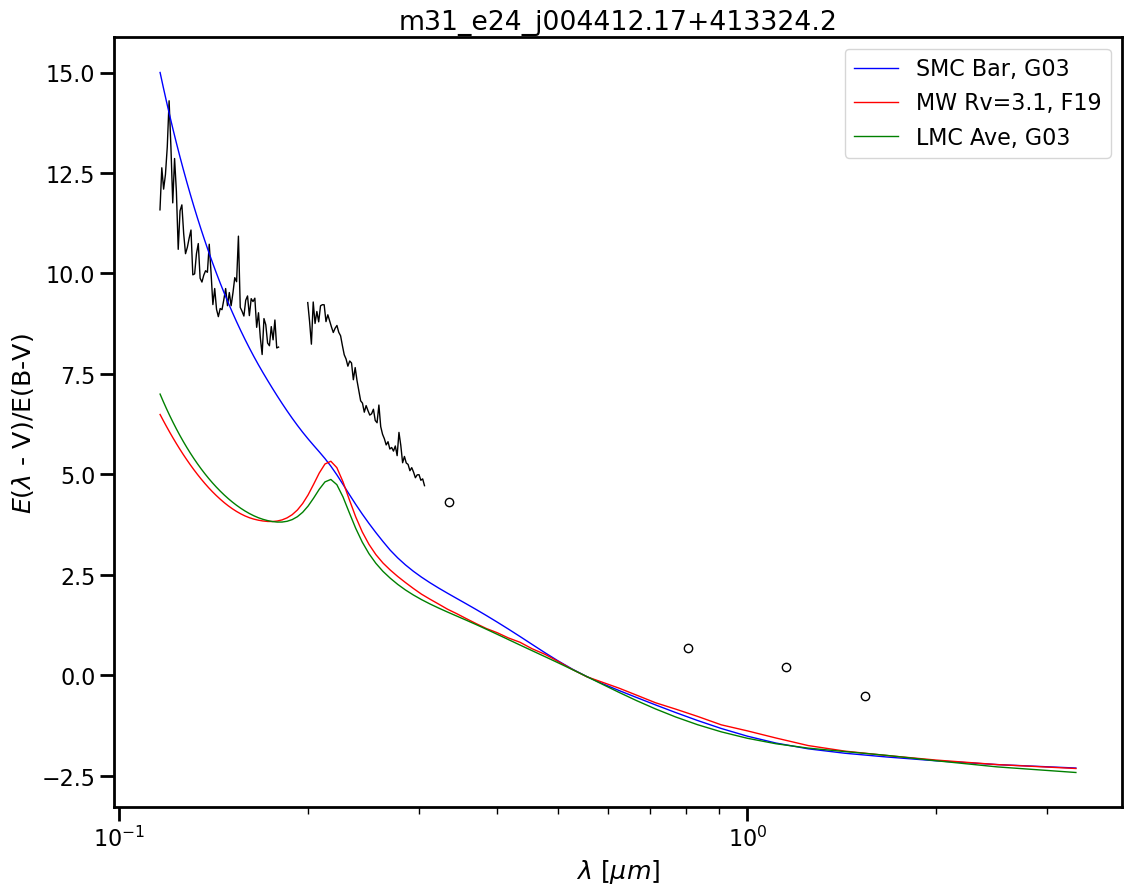

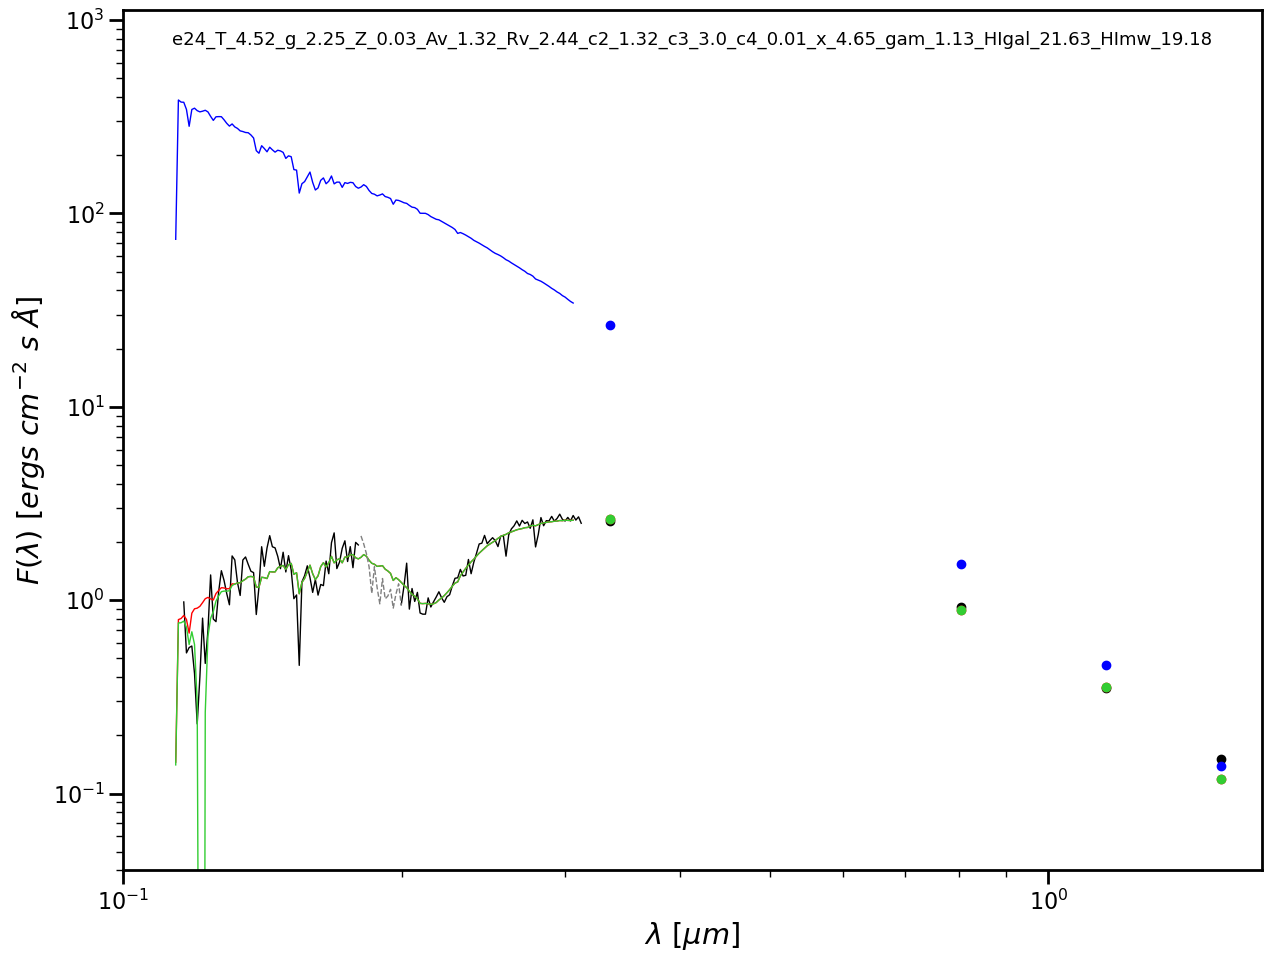

In [114]:
# Calculates all extinction curves
doall = True
singlevalued = True
save_ext_curve = True
plot_ext_curve = True
optimize_fit = False

adjust_spectra = True
fourband = False

# If get_uncert is True, it runs the MCMC sampler
get_uncert = False
excl_wls = False

beg_wls = [.1141, .1155] #.1148]
end_wls = [.3130, .3155] #.3136, .3155

# from stacked spectra
beg_wls=[.1141, .116]
end_wls=[.3136, .3155]

if doall:
    for i, s in enumerate(m31_list):
        print("Star", s)
        starname = m31_list[i]
        starstr = starname.split(gal_str)[1].split("_")[0]
        fstarname = f"{starname}.dat"
        
        if ('e22' in s) or ('e6' in s):
            print("getting models for 3-band photometry")
            fourband=True

        # Exlcuded regions individual per star
        excl_wls = exluded_wv(starstr)

        # Trim beg of spectrum with low flux
        if 'm31' in gal_str:
            # if ('e9' in s) or ('e2' in s): # or ('e6' in s) or ('e22' in s):
            #     add_excl = [.113, .117] #.12
            #     print("Additional excl WLs:", add_excl)
            # else:
            add_excl = excl_wls
            print('len excl wls', len(excl_wls))
            if len(excl_wls) > 2:
                add_excl = [excl_wls[2], excl_wls[3]]
        else:
            add_excl=False

        for j in range(len(m31_list)):
            if ('e22' in m31_list[j]) or ('e6' in m31_list[j]):
                print("getting models for 4-band photometry")
                fourband=True

        ex_regions = [
                    [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
                    [8.7, 10.0],  # bad data from STIS
                    [3.55, 3.6],
                    [3.80, 3.90],
                    [4.15, 4.3],
                    [6.4, 6.6],
                    [7.1, 7.3],
                    [7.45, 7.55],
                    [7.65, 7.75],
                    [7.9, 7.95],
                    [8.05, 8.1],
                ] / u.micron

        if add_excl:
            add_excl = [1./x for x in add_excl]
            print('add_excl um', add_excl)
            ex_regions = [
                [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
                [8.7, 10.0],  # bad data from STIS; zeros (for all stars)
                [3.55, 3.6],
                [3.80, 3.90],
                [4.15, 4.3],
                [6.4, 6.6],
                [7.1, 7.3],
                [7.45, 7.55],
                [7.65, 7.75],
                [7.9, 7.95],
                [8.05, 8.1],
                [5.13, 5.88],
                [2.94, 3.17],
                add_excl,
            ] #/ u.micron
        # excl_wls = [1./x for x in ex_regions]
        ex_regions = ex_regions/u.micron
    
        # if 'e12' in starstr:
        #     excl_wls = [.165, .205]
        # elif 'e13' in starstr:
        #     excl_wls = [.165, .205]
        # elif 'e14' in starstr:
        #     excl_wls = [.165, .21]
        # elif 'e17' in starstr:
        #     excl_wls = [.185, .19]
        # elif 'e18' in starstr:
        #     excl_wls = [.18, .2]
        # elif 'e6' in starstr:
        #     excl_wls = [.18, .2]
        # elif 'e24' in starstr:
        #     excl_wls = [.18, .2]
        # elif 'e1' in starstr:
        #     excl_wls = [.175, .21]
        # elif 'e4' in starstr:
        #     excl_wls = [.17, .2]
        # elif 'e5' in starstr:
        #     excl_wls = [.18, .2]
        # elif 'e7' in starstr:
        #     excl_wls = [.17, .19]
        # elif 'e8' in starstr:
        #     excl_wls = [.165, .2]
        # elif 'e22' in starstr:
        #     excl_wls = [.168, .19]
        # else:
        #     excl_wls = False #[.1601, .1602] # excl_wls = [.17, .2]

        print('excl_wls', excl_wls)
        print('add_excl', add_excl)
        print('ex_regions', ex_regions)

        # get all data (do not exclude)
        # red_star_a, \
        # band_names_a, \
        # data_names_a, \
        # gindxs_a, \
        # excl_fluxes_a = get_red_star(fstarname, file_path, excl_wls=[.1001, .1002])
    
        # if len(m31_list_old_uv_order) < 4:
        #     beg_wls = [.1141, .116]
        #     end_wls = [.311, .3155]
        # else:
        #     beg_wls=[.1141, .116]
        #     end_wls=[.3136, .3155]
    
        # # get only non-excluded data
        # reddened_star, \
        # band_names, \
        # data_names, \
        # gindxs, \
        # excl_fluxes = get_red_star(fstarname, file_path, excl_wls=excl_wls, beg_wls=beg_wls, end_wls=end_wls) # .1148


        # Read in star data, exclude wavelength regions
        reddened_star, \
        band_names, \
        data_names, \
        gindxs, \
        excl_fluxes = get_red_star(fstarname, 
                                   file_path, 
                                   excl_zero=True,
                                   excl_wls=excl_wls, # ex_regions, #
                                   fourband=fourband,
                                   nof275w=nof275w,
                                   beg_wls=beg_wls,
                                   end_wls=end_wls)

        reddened_star_a, \
        band_names_a, \
        data_names_a, \
        gindxs_a, \
        excl_fluxes_a = get_red_star(fstarname, 
                                     file_path, 
                                     excl_zero=True,
                                     excl_wls=excl_wls, #ex_regions, #
                                     get_excl_inds=True,
                                     fourband=fourband,
                                     nof275w=nof275w,
                                     beg_wls=beg_wls,
                                     end_wls=end_wls)

        # 2nd attempt
        # reddened_star_a, \
        # band_names_a, \
        # data_names_a, \
        # gindxs_a, \
        # excl_fluxes_a = get_red_star(fstarname, file_path, excl_wls=[.1001, .1002], 
        #                              get_excl_inds=True, beg_wls=beg_wls,
        #                              end_wls=end_wls)
        # norm_data = np.average(reddened_star.data["BAND"].fluxes)
        
        # plot excluded regions, only for spectra
        # if cspec == 'STIS':
        #     ax.plot(
        #         reddened_star_a.data[cspec].waves[gindxs_a],
        #         reddened_star_a.data[cspec].fluxes[gindxs_a] / norm_data,
        #         color='gray',
        #         ls='--', lw=1)


        # print('gindxs check', gindxs)
        # print('gindxs_a check', gindxs_a)
        
        # Adjust spectra
        if adjust_spectra:
            spec_adj = spec_corr(galaxy, starstr)
            print('spec adjust', spec_adj)
            reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))
            reddened_star_a.data["STIS"].fluxes = (reddened_star_a.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))

        # Need to adjust spectra for e17, e18, e24
        for j in range(len(m31_list)):
            if ('e17' in m31_list[j]) or ('e18' in m31_list[j]): # or ('e24' in m31_list[j]):
                spec_adj = spec_corr(galaxy, starstr)
                reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))
                reddened_star_a.data["STIS"].fluxes = (reddened_star_a.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))

        # Remove negative fluxes
        (nvals,) = np.where(reddened_star.data["STIS"].fluxes.value < 0)
        reddened_star.data["STIS"].npts[nvals] = 0
        (nvals0,) = np.where(reddened_star.data["STIS"].fluxes.value == 0.)
        reddened_star.data["STIS"].npts[nvals0] = 0
        # print('len nvals for negative fluxes', len(np.where(nvals==True)))
        # print('len nvals for zero fluxes', len(np.where(nvals0==True)))

        reddened_star.data["STIS"].fluxes[reddened_star.data["STIS"].npts == 0] = np.nan

        # Rebin spectra
        reddened_star.data["STIS"].rebin_constres(rwaverange, gres)
        
        # reddened_star_a already rebinned in get_red_star
        # reddened_star_a.data["STIS"].rebin_constres(rwaverange, gres)
        
        # Set up parameter ranges; Relevant if testing initial values
        initial_grid, logtgrid, logggrid, logzgrid, \
        avgrid, rvgrid, c2grid, c3grid, c4grid, \
        x0grid, gammagrid, \
        hi_galgrid, hi_mwgrid = setup_param_ranges(starname, starstr, small_vary=False)
        
        do_calc(reddened_star,
                gindxs, 
                excl_fluxes,
                add_excl,
                reddened_star_a,
                gindxs_a,
                initial_grid, 
                singlevalued, 
                excl_wls,
                ex_regions,
                get_uncert, 
                save_ext_curve,
                plot_ext_curve,
                optimize_fit
                )

### Correct ext curve for HI foreground correction

In [273]:
t = Table.read('hi_foregrounds_m31_id.fits')
forehi_orig = t["nhi"]
forehi_unc = t["nhi_err"]
print(forehi_orig)
print(forehi_unc)
# header = f[1].header
# print(data)
# print(header)

       nhi        
------------------
 6.519803597760585
 6.669826715095945
 6.615055577694329
 6.597319523601287
 6.618995165033147
 6.619643754386162
 6.775928314084413
 6.421944955741814
 6.577322805309673
 6.513934925948378
 6.299305262801741
 6.416919560027183
 6.415784686328932
 5.018169037359711
4.9953736169364635
 5.137838034009799
 6.607125001318579
      nhi_err       
--------------------
0.013488307252865818
0.013670584316150104
 0.06659810793194311
0.059052796707024756
 0.06615367776059909
 0.06749969807656035
 0.08476707025393629
 0.07362957415298542
   0.075621132406199
  0.0775123834073685
 0.07702820893871837
 0.07968101132605995
 0.07927085931139352
0.043141284286521184
0.046421443648350394
 0.04952097793060442
  0.0576093466186896


# Plot FM parameters

In [54]:
print("galaxy", gal_str)
if 'm33' in gal_str:
    m31_list = ["m33_e1_j013334.26+303327", 
                 "m33_e2_j013339.52+304540",
                 "m33_e4_j013344.59+304436",  
                 "m33_e7_j012241.93+304728"]
elif 'm31' in gal_str:
    m31_list = [
        #"m31_e1_j004354.05+412626.0",
        "m31_e2_j004413.84+414903.9", "m31_e3_j004420.52+411751.1",
        "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
        #"m31_e6_j004438.71+415553.5",
        "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
        # "m31_e10_j004512.73+413726.4", # No STIS data, "m31_e11_j004535.40+414431.5", # No STIS data
        "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
        "m31_e14_j004543.46+414513.6","m31_e15_j004546.81+415431.7",
            ]
# M31 FM90 params
# c2 = [1.182, 0.984, 1.259, 1.155, 0.842, 1.147, 0.665, 0.84, 1.06, 1.24, 1.36]
# c3 = [2.13, 1.212, 1.0975, 2.165, 1.37, 1.21, 1.88, 2.14, 2.31, 1.39, 1.89]
# c4 = [0.118, 0.117, 0.0242, 0.067, 0.019, 0.153, 0.241, 0.011, 0.01, 0.02, 0.05]
# x0 = [4.795, 4.627, 4.817, 4.724, 4.74, 4.7, 4.6, 4.78, 4.87, 4.88, 4.85]
# ebv = [0.333, 0.355, 0.3988, 0.386, 0.54, 0.43, 0.37, 0.48, 0.464, 0.53, 0.39]
# gamma [0.88, 0.6, 0.758, 0.944, 1.098, 0.677, 0.959, 0.862, 1.068, 0.604, 0.947]

    
    
# for i, star in enumerate(m31_list):
#     starstr = star.split(gal_str)[1].split("_")[0]
#     print("star", star)
#     print("starstr", starstr)

#     results_file = "params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat"

#     with open(results_file, 'r') as f:
#         x = [float(line.strip()) for line in lines if line]
#         print("x", x)
#         print("type x", type(x))
        
# #     with open(results_file, 'r') as f:
# #         lines = (line.strip() for line in f if line)
# #         print("lines", lines)
# #         x = [float(line) for line in lines]
# #         print("x", x)

#     resdata = np.fromfile(results_file, dtype="float", sep="\n")
#     print("resdata", resdata)
#     logt = [resdata[0]]
#     logg = [resdata[1]]
#     logz = [resdata[2]]
#     av = [resdata[3]]
#     rv = [resdata[4]]
#     c2 = [resdata[5]]
#     c3 = [resdata[6]]
#     c4 = [resdata[7]]
#     x0 = [resdata[8]]
#     gamma = [resdata[9]]
#     hi_gal = [resdata[10]]
#     hi_mwgrid = [resdata[11]]
#     hi_av = [resdata[12]]
#     hi_ebv = [resdata[13]]
    
#     print("star", star)
#     print("logt", logt)
#     print("logz", logz)

    #f = open("params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat", "r")
    
#     r = f.read()
#     for j in range(15):
#         print(j)
#         print(r[j])
    

# for k, val in enumerate(params_per):
#     f.read(
#         "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#         )
#     )

logt=[]; logtp50=[]; logtp1sig=[]; logtm1sig=[]
logg=[]; loggp50=[]; loggp1sig=[]; loggm1sig=[]
logz=[]; logzp50=[]; logzp1sig=[]; logzm1sig=[]
av=[]; avp50=[]; avp1sig=[]; avm1sig=[]
rv=[]; rvp50=[]; rvp1sig=[]; rvm1sig=[]
c2=[]; c2p50=[]; c2p1sig=[]; c2m1sig=[]
c3=[]; c3p50=[]; c3p1sig=[]; c3m1sig=[]
c4=[]; c4p50=[]; c4p1sig=[]; c4m1sig=[]
x0=[]; x0p50=[]; x0p1sig=[]; x0m1sig=[]
gamma=[]; gammap50=[]; gammap1sig=[]; gammam1sig=[]
higal=[]; higalp50=[]; higalp1sig=[]; higalm1sig=[]
himw=[]; himwp50=[]; himwp1sig=[]; himwm1sig=[]
p1=[];p2=[];p3=[];p4=[];p5=[];p6=[];p7=[];p8=[];p9=[];p10=[];p11=[];p12=[]

p = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]

plt.figure(figsize=(20,15))

for i, star in enumerate(m31_list):
    starname = star
    starstr = starname.split(gal_str)[1].split("_")[0]
    results_file = "params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat"

    with open(results_file) as fin:
        data = (i for i in fin if not i.isspace())
#         print("data", data)
#         print(data[0])
        resdata = np.fromfile(results_file, dtype="float", sep="\n")
        j=0
        for row in data:
            p[j].append(row)
            print("row", row)
            print("type row", type(row))
            print("float(row[2])", float(row[2]))
            sig=(float(row[2]) - float(row[3]))/2
            print("sig", sig)
            j+=1
            if j < 7:
                row = next(data)

                
# plt.subplot(231)
# plt.subplot(232)
# plt.subplot(233)
# plt.subplot(234)
# plt.subplot(235)
# plt.subplot(236)

# plt.savefig(savefile_path + "fmparams/fm_1.png", bbox_inches='tight')

galaxy m31_
row 4.694151866692288 4.693642450493978 0.041914705021047105 0.00180619833925455 # logT

type row <class 'str'>
float(row[2]) 6.0
sig -1.5
row 0.09043416532084692 0.09095418484937859 0.0016587150419656999 0.021206892294348648 # logZ

type row <class 'str'>
float(row[2]) 0.0
sig -4.5
row 2.790973238918475 2.8129902531168383 0.02279568837659296 0.013486559222494865 # Rv

type row <class 'str'>
float(row[2]) 7.0
sig -1.0
row 2.1287680990476576 2.2380208483402697 0.08064768280370105 0.08539199842891021 # C3

type row <class 'str'>
float(row[2]) 1.0
sig -0.5
row 4.794502139223515 4.810343863197098 0.028429507455979497 0.013076391947438815 # x0

type row <class 'str'>
float(row[2]) 7.0
sig -1.0
row 17.001855226130626 17.30195360926112 0.4553675628288971 0.25469450433289964 # HI_gal

type row <class 'str'>


ValueError: could not convert string to float: '.'

<Figure size 1440x1080 with 0 Axes>

### Calc & save ext curve with new best fit params
#### (now fit_params = params; also params_best = params &  pnames_extra = pnames)

In [23]:
# intrinsic sed
modsed = modinfo_rb.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo_rb.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo_rb.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo_rb.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save("extcurves/" + starstr + "_ext2.fits", column_info=col_info)

NameError: name 'fit_params' is not defined

### Plot new best-fit model spectra

In [21]:
def plot_new_bf_spectra(hi_ext_modsed, reddened_star):
    """
    """""
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(13, 9.5))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves,
        #        weights[cspec], 'k-')

        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # print(reddened_star.data[cspec].waves)
        # print(modinfo.waves[cspec])

        ax.plot(
            modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
        )
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
    ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    # fig.tight_layout()
    plt.title(starname)
    plt.savefig(savefile_path + starstr + "_spectra2" + ".png")

NameError: name 'hi_ext_modsed' is not defined

### Plot new best-fit extinction curve

True


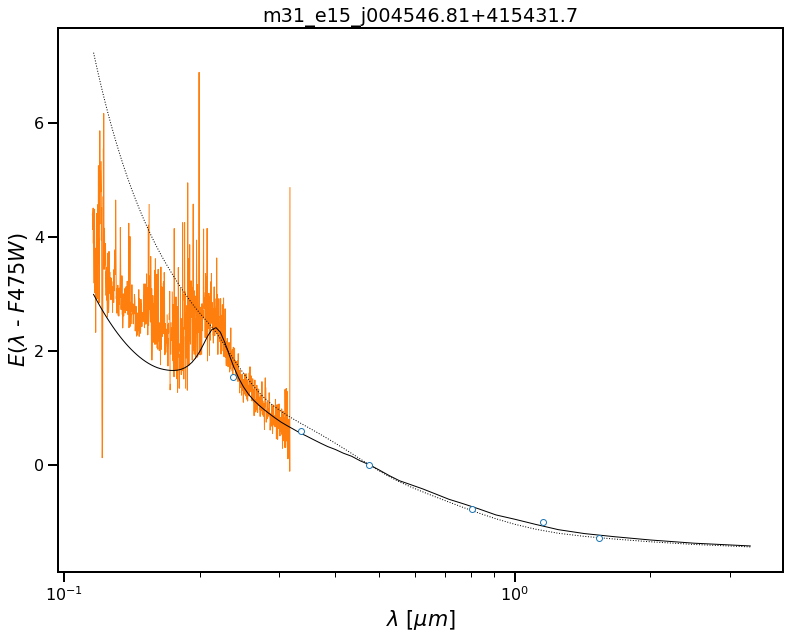

In [168]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
# extdata.trans_elv_alav()

# def trans_elv_elvebv
extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
#ax.set_ylim(0.0, 10.0)
# ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.set_ylabel(fr"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
# ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")
Af475wAv = smcbar(0.475 * u.micron)
smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, smcbar_el475w, "k:")

f19_rv31 = F19(Rv=3.1)
# ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")
# ax.set_xlim(0, 7.5)
Af475wAv = f19_rv31(0.475 * u.micron)
f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, f19_el475w, "k-")
plt.title(starname)
plt.savefig(savefile_path + starstr + "_extcurve2" + ".png")


### Plot new spectra function 

In [284]:
def plot_spectra_with_mod(modinfo, hi_ext_modsed, reddened_star, modsed, ext_modsed, \
                          modsed_stardata, starstr, params, initial_grid):
    """
    """
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(14, 12))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves, weights[cspec], 'k-')

        # Observations
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # Intrinsic SED
#         print("test rebinned intrinsic wavelengths", modinfo.waves[cspec])
#         print("test rebinned intrinsic fluxes", modsed[cspec] / norm_model)
        ax.plot(
            modinfo.waves[cspec], 
            modsed[cspec] / norm_model, 
            "b" + ptype, label=cspec
        )
        
        # dust_extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        
        # h(i) abs sed
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
#     ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    fig.tight_layout()
    
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4",
    #"x0","gamma","HI_gal","HI_mw"]

    logt_round = np.around(params[0], decimals=2)
    logg_round = np.around(params[1], decimals=2)
    logz_round = np.around(params[2], decimals=2)
    av_round = np.around(params[3], decimals=2)
    rv_round = np.around(params[4], decimals=2)
    c2_round = np.around(params[5], decimals=2)
    c3_round = np.around(params[6], decimals=2)
    c4_round = np.around(params[7], decimals=2)
    x0_round = np.around(params[8], decimals=2)
    g_round = np.around(params[9], decimals=2)
    higal_round = np.around(params[10], decimals=2)
    himw_round = np.around(params[11], decimals=2)
    print("Fig params are log(T)=%s, log(g)=%s, Av=%s" % (params[0], params[1], params[3]))
    
    # Generate a name to record the star and its parameters
    param_combo_str = "_T_" + str(logt_round)  + "_g_" + str(logg_round) + \
                "_Z_" + str(logz_round) + \
                "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + \
                str(c2_round) + "_c3_" + str(c3_round) + "_c4_" + str(c4_round) + "_x_" + \
                str(x0_round) + "_gam_" + str(g_round) + \
                "_HIgal_" + str(higal_round) + "_HImw_" + str(himw_round)
    
#     ax.set_title(starstr + param_combo_str, y=0.95, fontsize=13)
    
    # Title with initial value for initial pos
    param_combo_str_init = "_T_" + str(initial_grid[0][0])  + "_g_" + str(initial_grid[1][0]) + \
                "_Z_" + str(initial_grid[2][0]) + \
                "_Av_"  + str(initial_grid[3][0]) + "_Rv_" + str(initial_grid[4][0]) + "_c2_" + \
                str(initial_grid[5][0]) + "_c3_" + str(initial_grid[6][0]) + "_c4_" + str(initial_grid[7][0]) + "_x_" + \
                str(initial_grid[8][0]) + "_gam_" + str(initial_grid[9][0]) + \
                "_HIgal_" + str(initial_grid[10][0]) + "_HImw_" + str(initial_grid[11][0])

    # Set title to updated initial position, param_combo_str
    ax.set_title(starstr + param_combo_str, y=0.95, fontsize=15)
    
    if 'e6' in fstarname:
        ax.set_xlim(0.1, 1)
#     elif 'e2' in fstarname:
    ax.set_ylim(0.01, 250)

#     plt.savefig(savefile_path + "spectra_w_mod/" + starstr + "_rb_" +  str(gres) + "_res.png")
    plt.savefig(savefile_path + "starting_positions_retry/" + str(starstr) + "/" + starstr + "_rb_" +  \
                str(gres) + param_combo_str + ".png")
    print("Saved spectra w mod")

## Plot ext curve param results (put at end)

In [118]:
m31_results = [
    #"m31_e1_j004354.05+412626.0", # Prob. w sorting by UV slope; bad fit, no uncert. results
    "m31_e2_j004413.84+414903.9",
#     "m31_e3_j004420.52+411751.1",
#     "m31_e4_j004427.47+415150.0",
#     "m31_e5_j004431.66+413612.4",
#     "m31_e6_j004438.71+415553.5", # bad fit, no uncert. results
#     "m31_e7_j004454.37+412823.9",
#     "m31_e8_j004511.82+415025.3",
#     "m31_e9_j004511.85+413712.9", # some problem with walkers
#     "m31_e12_j004539.00+415439.0",
#     "m31_e13_j004539.70+415054.8",
#     "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
#     "m31_e15_j004546.81+415431.7",
]

# best fit, p50, p50 + 1sig, p50 - 1sig
logt=[]; logtp50=[]; logtp1sig=[]; logtm1sig=[]
logg=[]; loggp50=[]; loggp1sig=[]; loggm1sig=[]
logz=[]; logzp50=[]; logzp1sig=[]; logzm1sig=[]
av=[]; avp50=[]; avp1sig=[]; avm1sig=[]
rv=[]; rvp50=[]; rvp1sig=[]; rvm1sig=[]
c2=[]; c2p50=[]; c2p1sig=[]; c2m1sig=[]
c3=[]; c3p50=[]; c3p1sig=[]; c3m1sig=[]
c4=[]; c4p50=[]; c4p1sig=[]; c4m1sig=[]
x0=[]; x0p50=[]; x0p1sig=[]; x0m1sig=[]
gamma=[]; gammap50=[]; gammap1sig=[]; gammam1sig=[]
higal=[]; higalp50=[]; higalp1sig=[]; higalm1sig=[]
himw=[]; himwp50=[]; himwp1sig=[]; himwm1sig=[]
p1=[];p2=[];p3=[];p4=[];p5=[];p6=[];p7=[];p8=[];p9=[];p10=[];p11=[];p12=[]

p = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
# for k, val in enumerate(params_per):
#     f.write(
#         "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#         )
#     )
#f.write("# best fit, p50, +unc, -unc\n")

# Read in fit values
for i, star in enumerate(m31_results):
    starname = star
    starstr = starname.split(gal_str)[1].split("_")[0]
    results_file = "params_dat/" + starstr + "_fit_params.dat"

    with open(results_file) as fin:
        data = (i for i in fin if not i.isspace())
        print("data", data)
        j=0
        for row in data:
            p[j].append(row)
            print(row)
            j+=1
            if j < 7:
                row = next(data)

    print(p)
#     
#     ipdata = np.fromfile(results_file, dtype="float", sep="\n")
#     print(ipdata)
#     logg.append([ipdata[1]])
#     logz.append([ipdata[2]])
#     av.append([ipdata[3]])
#     rv.append([ipdata[4]])
#     c2.append([ipdata[5]])
#     c3.append([ipdata[6]])
#     c4.append([ipdata[7]])
#     x0.append([ipdata[8]])
#     gamma.append([ipdata[9]])
#     HI_gal.append([ipdata[10]])
#     HI_mw.append([ipdata[11]])

data <generator object <genexpr> at 0x7fe5d4b1e450>
4.740334323488035 4.720856487354006 0.013529512828514889 0.0624197943401521 # logT

0.12215133428859155 0.09814391806892488 0.024976488195594365 0.015346901345937775 # logZ

2.7882822368557316 2.785400311391983 0.013110457907309137 0.08745751605367857 # Rv

1.3706544827143778 1.4854677806800254 0.4242025430187235 0.09459494574376204 # C3

4.706031216614668 4.703716160298124 0.009524804283738142 0.02232121690192912 # x0

17.214366297626526 17.74036796872021 4.1065032768429255 0.65625008504637 # HI_gal

0.3339587616706861 0.3228745786632307 0.011338121862540296 0.010367198172903713 # E(B-V)

1.759287121735708e+17 6.018784288322455e+17 8.346946299972925e+21 4.69694982431252e+17 # N(HI)/A(V)

4.905389031064722e+17 1.675897632975754e+18 2.2585297291353086e+22 1.3070545041231828e+18 # N(HI)/E(B-V)
[['4.740334323488035 4.720856487354006 0.013529512828514889 0.0624197943401521 # logT\n'], ['0.12215133428859155 0.09814391806892488 0.0249764881